In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

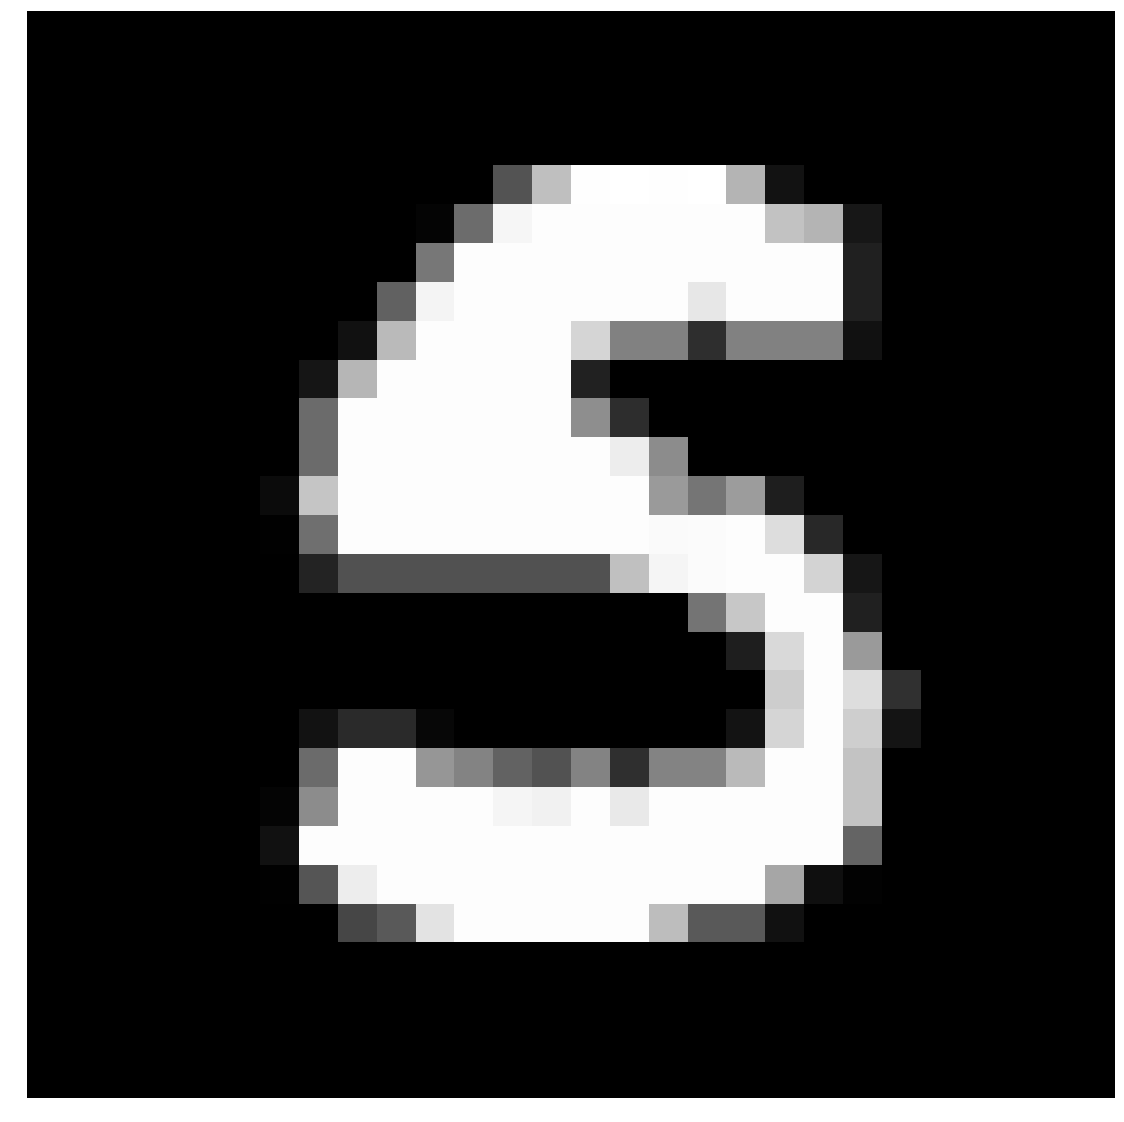

In [2]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

(trainX, trainy), (testX, testy) = mnist.load_data()
zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [137]:
#Tworzę większą tablicę zer i "wkładam" w nią X - array
def my_pad(X, a, b, c, d):    
    Y=np.zeros((X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2]), dtype='float64')
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y

def conv_forw(X, mat):
    Z=np.zeros((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_back(X, mat, Der):
    Z=np.ndarray((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    matd=mat*0
    Z=Z*0
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    return (Z, matd)

def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    silver_in_blood=np.asarray([[0]*(Y.shape[1]//mat[1])]*(Y.shape[0]//mat[0]))
    
    Exit=np.zeros(Y.shape, dtype='float64')
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.zeros(Y.shape, dtype='int64')
    Truth2=np.zeros(Y.shape, dtype='int64')
    Pure=np.zeros(Y.shape, dtype='float64')
    
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[list(range(i, Y.shape[0], mat[0]))][:,list(range(j, Y.shape[1], mat[1]))]
            #Bleeding_One=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
            
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)

def pool_back(X, mat, dim):
    Y=np.ndarray((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(list(range(i,Y.shape[0],mat[0]))),np.asarray(list(range(j,Y.shape[1],mat[1]))))]=X
    Y=Y*dim
    return Y


def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0

def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    for i in range(pred.shape[0]):
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.0000001):
                pred[i,0]=0.0000001
            elif(pred[i,0]>0.999999):
                pred[i,0]=0.999999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
    return (der, summ)

#ccn - learning rate, loopz - number of iterations, streetcleaner - hardcoded number of weights in first Fully connected layer
ccn=0.02
loopz=60000
streetcleaner=1690

matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)

#img=cv2.imread("E:\W3\GGHard.jpg")
w1=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
w2=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(10*20)]).reshape(10,20))

m2=[0]*10
m3=[0]*10
m4=[0]*10
m5=[0]*10
m6=[0]*10
m7=[0]*10
m8=[0]*10
mtb2=[0]*10
mtb3=[0]*10
mtb4=[0]*10
mtb5=[0]*10
mtb6=[0]*10
mtb7=[0]*10
mtb8=[0]*10


sk=[0]*loopz
t1=time.time()
for jj in range(loopz):
    img=trainX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""
    
    #Forw - Konwolucja, Relu, Pooling
    
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])
    
    """#Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""

    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    s2=sigmoid_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)
    
    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[trainy[jj],0]=1
    der, suma=cost(dp, s4)
    sk[jj]=suma
    print(suma)
    
    #Back - 2.FC
    dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
    weight_delta2=dk2*s2.T
    dk1=w2.T*dk2

    #Back - 1.FC
    dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
    weight_delta1=dk1*m9.T
    dk0=w1.T*dk1
    

    #Back - 2*Konw, RElu, Pooling
    #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
    dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])
    
    """for i in range(10):
        mtb8[i]=pool_back(dkl[i], (2,2), Face2)
        cz=m6[i].shape
        nw=mtb8[i].shape
        mtb8[i]=mtb8[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        #print(m6[i].shape, mtb8[i].shape)
        mtb7[i]=relu_back(m6[i], mtb8[i])
        mtb6[i], Dr2=conv_back(m4[i], matt2[i], mtb7[i])"""
    
    for i in range(10):
        #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
        mtb5[i]=pool_back(dkl[i], (2,2), Face1)
        cz=m3[i].shape
        nw=mtb5[i].shape
        mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        mtb4[i]=relu_back(m3[i], mtb5[i])
        mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])

    w1-=weight_delta1*ccn
    w2-=weight_delta2*ccn
    matt-=Dr*ccn
    #matt2-=Dr2*ccn
    

t2=time.time()
print(t2-t1)
print(s4)

10.76618325928407
9.606764578615266
6.059556665996598
6.994345490448962
7.656543196949295
8.657977814837178
7.350533009308172
10.333635126588543
5.893739567768821
5.480126122961846
9.764925192251786
8.965986287256372
6.928863351340037
6.800529174910342
5.709250777926879
7.173113758268631
5.858408843282906
6.782815668705408
4.584273955067435
4.778918308269778
3.3206955915784344
5.022842986653402
4.703625280623097
3.6347427675745303
3.8373011190072517
4.819626419123702
4.412153522042689
6.032886606245858
4.705121187707264
5.162871377873991
5.108741101155723
5.045016367390631
3.8167329423661776
3.8347682739606404
4.145916039415588
4.920552837595965
3.611430879348229
4.391915894265601
4.1729979157253005
3.4051718258400814
3.9485443811731407
4.286975765299618
6.252259273385235
3.123534391724497
3.731660078025787
3.553844015030665
3.9656888132078594
3.8664139157090105
3.8635148788297586
3.8708512437639575
4.753521993215071
4.878081100474632
4.851065665473081
3.2320394926214795
2.953780333190

2.531123880430154
2.8228854479660406
1.9972213280003717
3.341126462264153
3.6343920848237006
3.428942759431739
1.7858147008780956
1.8293717632503474
3.0255525433239683
2.266215083853831
2.742723126318705
3.333392331497481
2.920925055391798
1.8893484514071657
2.399756654982767
3.229394352135577
2.3891100105535408
3.132274176855522
2.5064879429162676
2.5036996284563044
3.6671651649550405
3.7740797615462007
2.80664195657633
3.199478322032955
3.112459851457622
2.1312374887313763
3.5908402880598937
2.0465896431849018
2.7927954172281
1.9252147177807333
3.431986612053798
3.447077586023129
3.4051951426404266
2.9749161262634374
2.841237569192823
2.8505821901737463
1.5549491687630517
3.3038538633398784
2.3553417105868313
2.8740827649248923
2.9778002614779764
2.9515809069272163
2.748477312027409
2.643819616757695
1.8486566916972278
2.3492180107994005
2.1242782868507906
2.6662644678305436
2.851397559061667
3.420923629525161
2.8299797370037236
2.92393141739231
4.53802758827693
3.367946770433844
3.0

2.832876063644448
2.4643181311008413
2.3574769994366367
2.5443978390707143
1.3386578977209198
3.282248100140851
3.5133871843181725
2.5772018230403777
1.8974520114171483
4.206480181759459
3.0325901906159776
2.633521446086442
1.930063379833918
2.6097669953122753
2.5557488816681806
2.7539489380315394
2.239000727988322
2.0049507554285393
1.4527371371284308
3.3648430559539078
2.9918827266291235
1.4162330450918668
2.604263335961453
2.8544890467759902
2.425449868523091
1.8494080938393078
1.6570950350628233
1.4921363963297305
2.4109502376484895
3.286417783415767
2.58814053631885
2.479966822898226
2.916305068857529
1.5505396245865937
1.991584226688948
1.7184401543638017
3.829658538478842
3.214404423793018
1.9640011610387653
2.0612298694830873
3.4956687201743146
1.5645343424384102
3.0161240578605875
2.528129181063855
2.0263807967671768
3.447623909630673
3.779594218282963
2.2346224681933267
1.6425568494123437
1.9449629960312567
3.653535708507062
3.2226864215854367
1.825970605923862
3.687099484784

3.389603483861737
2.2155653273560287
2.950302254455544
2.0373327054683505
3.3591348056997803
1.4349592944075076
2.135998547052612
2.786975293861728
3.28480350780449
2.4337299111981685
5.0004585689950956
1.0246444857441728
1.5150046082036126
1.8936439650773835
2.5374450252062952
3.0098320459119945
1.4936678118756916
2.161610753745772
2.3506476963799052
2.8353237219351004
3.004430267848943
2.4042036859857214
2.3626410307720933
1.5316048155075115
1.8335057078403507
1.7358975792760092
2.272273883207333
1.3968566091888905
1.3088611887067998
1.609409734900043
1.644442354205306
2.1943018781689383
2.710120081795507
1.5531303849624871
4.472377902562164
2.6172961611671868
2.3498407522056337
1.8308666764003552
2.4117542412153963
1.1541462197551615
4.06555232038062
1.8840045265724472
2.4410195084534276
1.7467259373173645
1.4899851205535704
2.4926870189163295
2.8440318661443365
1.9134395350032944
1.892604074421284
1.4512017450944414
1.381899017196979
2.806882667386923
1.1433142214968297
1.838227939

1.7305845137560456
2.8638466222668573
3.064388710392717
1.385253481341662
0.9565862077674576
1.9428439714554864
1.1002485490945189
3.2729041018292473
2.6609228199479023
2.1607197942132172
1.5225133099225074
2.318192671891813
3.451956000595261
1.595502722480888
1.4842511321732108
1.7794226440388914
2.5223531074969996
1.6612693897124513
1.013946458351538
1.1757541990972422
1.2099124213516075
1.9844319750869295
2.6446927728440786
4.087123181773071
1.0335894553286116
2.4664470540577845
1.3359577401291707
2.408442724922483
2.1379275958141326
3.7204665321752564
2.5366230673425556
2.612543665489021
0.8757947367515756
1.224151562811933
3.5023409802203815
1.4144849936325046
1.51822407318476
3.009807628301941
1.574934374491749
1.3103218967928343
1.7906814684165666
2.4144379894587154
1.1269289628028445
3.376490454397649
1.322818884666611
1.528367629578052
2.1978806120507928
1.3097531496130363
0.8752780084713339
2.269130244308004
1.080384295655663
2.6302246959741122
1.3735937595370769
3.5329491887

1.1034614863435093
0.6889482197581794
1.5049408430388023
1.198178790179545
1.2959822707265651
3.8987065005981787
1.6855412847293163
0.9327448322048069
3.4373397672536146
0.9942633914132841
1.4661212202111977
2.25776975959422
1.16932667154565
1.1810284239873141
0.7191692885289745
1.227414601947954
1.191561934163612
1.8766151095296266
2.810515919957865
1.6055705770376827
2.571453837770949
2.087240880229657
3.536157272568031
0.9521974425575505
3.6572800394503413
1.1996450705442416
2.4710379219207876
1.2193010609625752
1.6239993752385602
0.7888613573338839
0.6819222492093386
1.2326186889122344
2.442913349861905
1.3950243183852526
0.8224394895535375
1.2497451403118316
1.097676419752452
1.394972138792397
0.7874517106481472
2.0534479681096394
2.4831436020984623
2.540029027382272
2.7061452964069654
1.2523312429674858
1.8389687046672207
0.7834751728813754
2.06255841056128
1.120815547069545
1.7300938695388506
1.4886569257162436
3.012070414465575
2.8000751822421734
3.080273995409007
2.05339586366

3.3854483672778266
2.204958426970181
1.0681664572355778
1.900524459900144
2.970669744493286
0.9171007099234092
1.5584285546352776
2.3467641121328846
5.697691548085272
1.787823979059875
2.5141203212627286
2.7408568335314905
2.4875946638481166
1.933023929061931
3.6749179050048424
1.3126886983342112
1.0382037096557668
1.215712807747633
1.5324236170423418
1.8024548892878776
1.0601132461713982
1.3517179509247634
4.8370793741994005
0.6373918706010375
0.8760912263750814
1.2761023412997157
0.8278069395741857
0.7165593075317624
1.8696569760459625
1.4815713947952451
2.345742463631713
1.2637727471901736
1.7029205186436351
0.6884418600682625
2.143318588729368
1.8934876512077148
0.9328318126591515
1.8444354844893411
0.9898864412152576
2.9310106027922096
0.761006501612304
0.998860979143257
1.0890308817386143
0.7166690478058357
1.0579367299203595
4.093249525689068
4.3679733725990655
2.564924754331413
0.7552904377666159
0.7957885869642635
2.6117788034037805
0.7335674861577789
5.318336428636431
0.76410

0.4593756217354365
2.432666903344457
0.7075170011495058
0.7072434445902468
1.293947025645086
1.9111742602053512
2.4683035267173747
0.48993008964220963
1.474412338688722
0.6485231369265108
0.6922398004271155
1.477303404053263
0.9790055139107041
2.305509773240505
0.6095235376994531
1.5726019689560211
2.1661988841742756
0.9211404681503101
0.6963031335617277
0.42937866512361145
0.9372133818626532
5.431443237404542
0.6795603328458818
1.9397056683880967
2.8029913556764905
0.5897150186196425
0.7731709333259146
3.7303841821718495
1.522654137576077
1.2590456850478653
1.0906625202794502
1.7732891058217095
0.6687553679376588
3.3740517145751627
0.8500797986667816
1.9453863970560936
0.7255059068548171
3.0352626029882583
0.5962157848194252
1.188158738518201
0.9704929071549814
1.723831817917423
0.5861362079311833
1.4584413701685872
1.7050875081287253
1.2960012067427025
1.4642571801047908
0.8453671207780841
1.2564785756057006
1.3272955209187893
1.0572150334716572
2.136243974719058
2.0097758428486334
1

2.3409096560609504
2.6664829180613228
0.7113029170955582
1.2266112651237535
0.5174318882440185
1.3352394176455133
0.7481095277101669
2.466147401280339
1.164563396154314
1.0173170535640668
1.3386685260552489
0.8163082439827881
0.9816568960322822
1.2793024875928776
4.275676477382186
0.8149418605019171
3.803716490082031
3.598280744048328
2.251254713849054
2.5425959859563743
1.129423263213555
1.4705581402266312
1.385090457619665
0.968516650378394
0.6791830000561149
1.357223110780445
0.9197953683200388
1.49073755848579
1.170872086007127
0.4763652302098348
0.5729602413370588
2.636950532408849
1.430674531250184
1.2819124295475945
1.3221708385680366
2.639863607773977
2.399856109926361
1.3519178535658323
1.1688616439797785
0.5913173205323956
1.8067876995309675
0.6053413403386408
0.6798174207256249
1.1075035095742618
0.8848207249321364
2.3111401210481164
1.1722023011255303
0.8126824368930193
1.1103404341357277
1.324229137855316
1.1899405413351176
1.194783322372177
4.935870079466458
0.76800404684

0.7414905783767506
1.2771738729316742
0.6632844990931765
0.36556187422857944
2.4471466225084626
1.9519531298618744
1.36344536421468
2.3470889214238055
1.2567805575698776
1.0521507517502002
0.7191449847243825
1.4057460938292596
0.4641342086431494
0.46442444621582546
2.3571669760040797
1.2209093035262146
0.8327157113051726
2.667846166124772
0.4084130275129065
0.9958433782478101
0.4254147940485347
2.3861459175732636
1.5026907051682206
0.9166882418624507
0.8470567862384414
1.1238995835671977
0.9872611709260717
0.6981613815945565
1.3822458099572659
0.9446558544041501
1.1904846984686082
0.6358995041629983
3.1571749793391906
1.4862605754899736
0.5286809225933156
0.8911847757817462
1.0778690430314875
1.0835836390349
1.3656115842341452
0.7459298897201021
0.958159702265806
1.4735827543214124
0.9470906914445067
1.638550350327191
0.8342739936629306
0.823424110996732
0.6821067907995015
0.9419542581981523
1.0433185027623428
0.749287722979001
2.7867119765829913
0.715780787092307
0.9836324990529004
1.

1.7621787962463678
1.078447684536097
3.0835556237115465
0.7974110808547636
4.811792276060687
3.0428092139684915
1.3621766661688532
1.7627419230832653
0.8150861854650934
0.9841815238055527
0.6769500163975225
3.0964725066308265
0.6020857674906804
2.2242155254085936
2.3113040945419985
0.49620947984038843
3.790631505255764
0.4879778434952723
0.45568660053972193
1.1476661084045003
3.9646198360501854
3.6726934455845437
0.9250053656326757
0.36258320048833487
0.46908960439601
3.49819958717707
2.853416284899101
2.411542557993304
1.2839097041490204
0.4449109033722387
1.2880854630569811
0.92364517855005
0.67153613088012
0.8313230850791199
0.6072005556555842
1.1961137812731069
1.5528268903715972
0.4479398415083703
0.6049806097990289
0.5899623506996077
3.484563620938098
0.6477512922366464
0.8292567704410609
4.09082406909897
0.4633110103467725
3.512728039072955
1.1501245559453368
6.2711691017887015
1.3801661647473953
0.41184436431306987
0.4571804030925996
1.5902445143411494
0.7741660297313587
1.2527

0.8881023541193893
0.6248698535585965
0.5065320130753107
1.1403582822478242
1.5170221102839982
1.0553149247333542
0.9687060436898391
0.7435761220194153
1.0075950054979974
0.40261045498649695
0.8669313123565443
1.0248618604948918
0.281899776718289
2.2718002113322258
0.5596484220337342
0.9892814897249415
1.5018337101326722
3.6888151659554946
3.059075111311508
0.35829039822450953
2.086463571081929
1.0318126486839514
0.3942071968468467
1.1313745289669483
3.978693219450362
0.9372955078338987
1.4242276585328397
1.910909262624009
0.3963941996793394
0.41735514131660123
2.1213241759629757
1.2890832274540995
0.3071898828376172
1.8145778916452067
0.4228881390894674
0.47514163079488553
3.085707921699406
0.430801335952978
1.6381069735718885
0.6126753598677468
0.4814973537790284
1.3260709172045995
0.3094059609808669
1.1383614124870711
2.9573803454736263
0.938341648077445
2.4531548604385067
0.807626803541346
1.9852356398892814
1.851551711276087
2.5544436981274408
0.7762446045856853
1.9241751885650091

0.9494523729896781
0.47804889968207465
0.3893465708539578
0.8625261964382263
0.2968296428142509
1.1612138320479635
0.3961920329070405
1.006699372046206
0.4509893255957872
0.22742416063618612
1.1429484677918516
0.9280714040199719
1.1204373848353604
1.37632841407697
1.0240647077195049
0.834200157629103
1.133165313202072
1.6038019389625016
1.099276498763559
2.5169516796866604
1.4430324190330501
0.7416945008128156
0.4961085820305771
1.7574487630955005
0.34295107976752826
1.7512295345058149
0.8170045120855555
5.769835720252898
0.7771932333411425
2.2897886192627848
1.0683554191222704
1.0729799448919286
0.9788866407640804
0.6018879561204551
0.5726437959365849
2.511106988872579
1.1312164458090417
0.7904108718464915
1.0358608645711456
6.631437315204926
1.5460399424069444
0.7948529607877116
0.3959789711633943
0.679096630032292
0.4819911010836612
0.764680729199872
1.3366157759306623
4.162090951685517
1.2254676324603344
0.8616039901772983
0.8751383464855592
2.293815353970353
0.4373318548475117
3.6

0.3797208117278585
0.47379447812629266
4.144810217794128
0.7736320960914113
1.1019739403720625
0.9719491065683035
0.2666960936240455
0.44464754424344455
0.5126917609713642
3.4864914866468726
1.736174441426943
0.3501811906764036
2.978019306357508
2.78004482778058
1.7306560879522253
1.9526271215190485
1.7791892134625087
1.337719441096486
0.4246999659845848
1.11553672343775
1.498854179711587
1.1076320744998416
1.1896281014030547
0.3574952832682731
3.5880137801521297
0.8787848647152428
0.9171343776727723
1.5068377999204057
1.3753568182998932
0.7814814631384486
0.29466582484120923
3.274958037518078
0.8134968428716555
2.203321320990495
0.820473589972828
1.117044532775558
0.4335380438890818
1.7134210070150915
1.6996098484406184
1.3425244940135104
0.5085349243424866
2.8439072394161276
0.7627079667263823
2.5490743335142465
0.5647071784290463
1.2611591744987867
0.33921234975885156
0.6611762426518915
2.692020492076143
1.5630972663008469
3.7628289753006343
1.257881479410318
0.8352455655748252
3.86

1.1680195009905705
1.1179341700618632
2.870229580646299
0.3165168516377165
1.7571913275181146
1.505801831585304
0.40199006470541093
0.700609296313643
0.35666660292867713
2.529301831041993
0.5326405012559339
0.9252758585954963
0.5543360849605191
0.20869350138429207
0.6942745198703318
0.5900078734085645
0.4367202904978794
0.7999284556149855
1.2675194585182687
0.538479353515931
0.585586007086005
1.5234048227964492
3.9992081737097473
0.5963324212657537
0.5590756428361972
0.8220793865221298
2.4223660018394817
0.794022031421918
0.2016630242435871
0.730645918184907
1.9225969798583358
0.494714438572542
0.2594778386143162
0.8523649508251082
7.4925666518787
0.8626771629410425
2.1338894626836415
0.812226852351296
5.5060094864571045
1.5216920527567548
0.7027924063427486
0.3763293380451496
0.8172232398672319
5.342247610073729
1.7654534979659353
0.6339483256906007
0.33246470015421126
0.7160113115235557
2.554408255730257
0.3188267236689607
0.3416739302651703
0.49649222373448354
1.235517900649608
3.34

0.8013857393418775
0.6461744460651083
3.1622775319741145
0.9609036613217048
1.245976488871655
2.3958960321135496
1.3867212222932699
0.3117421342006505
1.698553768529801
1.6661954147657503
1.2439508046461818
0.9889965896737555
0.27273581322305995
1.046127730510649
4.61381173687872
0.9079039698113059
0.1805745246923081
0.2526056258021584
0.58918041897816
0.5427013183240584
0.35966868790549994
0.7431544074527576
0.2414162411730599
0.679970785650734
0.3169250722196729
1.0346966286587422
2.6010293941381804
0.4244360339975922
2.629324471516452
1.1107453331652613
1.096875818027633
0.78030680240892
0.21302378162047025
1.2967521096487404
0.7486243622282649
0.16289279406838097
0.3563351833366046
1.9447837203416132
0.4755100138560894
0.2835879803793366
4.094542441453466
0.41083073635547057
4.823269654464927
0.1556457448306195
1.1610752104684405
2.4347208392673725
2.068579030208914
0.26975377526975036
2.634358377536522
0.18437984175184285
0.5194772908787548
0.6331556956128604
0.1813840874758484
0.

0.84534425531464
0.582340592625698
0.630664233528496
1.0459969569766816
0.1913473153512408
2.8208856426010893
0.37944588518275985
1.3980949796648137
0.18716137399561245
0.6224173796765873
0.24180917417335385
2.485713884489357
1.3445217635608013
4.803375061428962
0.6087737669869475
0.12349207358465111
0.7871192524609112
0.9632832640226336
0.2779493385844042
0.6507367673126695
2.38746902184308
1.1274025158661334
1.6746048931528619
1.1460470508573481
4.525490100490295
0.831766256283005
0.5768306841085814
0.24672619272154786
0.49541784374535525
0.37658319213068653
0.24563726824435528
0.7346147981067186
0.5646994746016359
0.9661064561335581
0.6973613868141698
3.5451006884249763
0.5926218993044213
0.19158345874787336
0.5490211763412177
5.741018455854524
1.0973709371494689
2.6269589255907984
0.23869002434582695
2.6564191669929262
2.3483373861107224
4.334535886924626
1.074694378309253
0.5020132781798663
0.42034939092715445
2.4708178800020026
1.3471515701668155
0.34751354175406673
1.07168686506

0.6034090099626231
1.0460260030599915
2.5370498491371722
1.9295639617229525
1.610559796300457
0.37256157431849457
0.7964773776940791
0.12132915583997526
0.5695830768838533
0.16391588276230637
0.5563859459306358
0.18044415680769954
0.23354769670371692
0.6374778741566542
0.17832445890451284
1.234575366134025
2.834680745832438
0.2377913072559717
0.1801897952706024
0.4805650947997521
0.7179077732872584
0.38164466770517774
0.6426398791370144
0.2243774431003952
0.9544977072231557
0.8616737934778944
0.5221762790107182
0.2576049468353299
1.055448836920648
1.8212349016036702
2.5137290365675136
0.8349012471129051
0.6550960338652743
0.4243856849395245
1.1998074851143308
0.5813442610053726
0.6113226290788424
3.4107213438758186
3.4638481369177665
0.23343819621184178
0.7053993171004015
1.70061105152605
1.6684166979438022
2.3810030249255507
0.5726368698048121
2.0819805451270277
1.1906815419602235
0.674619305535406
1.885603283869607
0.1437190572579606
1.316058348765152
0.4409134588161281
1.55537884139

0.5745547554161977
0.7308344634114721
1.6733096347644834
0.3636073635613661
4.254429109065404
4.02004468914049
1.4644426730162885
0.49619056142634643
0.7701885384957322
2.2015081447248446
1.1989062094834182
0.8792071245358198
0.40432027091954925
2.8330801980465155
1.5866557061219084
1.5351108877006983
0.518204048779966
1.2171049722993816
0.8006140243698989
1.723008429743638
0.49526565457055977
3.5004963292997497
1.1518030471211351
4.726688626176062
0.14321244982827178
1.4322683228079658
0.348191630277255
1.3985156268645105
0.3487892753161077
0.882101960712527
1.2055600658133538
1.4884011617913444
0.3835637717129632
0.6942119937150446
0.4745645183198935
0.7868063789125568
0.20428355996850944
5.23687814985558
0.7326725099253014
1.504667968551844
0.9016391742773103
1.1992521630669488
1.3341487198270774
0.12403738269960073
0.719010780538568
0.31797517145876536
2.5454009483314475
1.1992607152976982
1.182263314215726
0.42398667193584133
2.5354266784104933
1.3584743890456763
0.970039158010625

0.8017388571252099
0.33499843389192796
1.1630101269828421
0.4433363574125416
2.024729412356196
2.0398729119179513
1.5495269970259362
1.1298595778167828
1.4998169667168884
1.7795317592848643
3.663133521798716
2.8268060224724603
2.5410890552712218
1.7817398218567857
2.192746990904497
0.5899096012681144
2.3175027761907683
0.4969140069009807
1.8183618979965026
0.43278437005416814
0.7152896735167253
1.1135736275985488
0.9959362252129114
1.2517383829369721
1.9067700835810695
1.570346860777733
1.3702737149367914
0.23196730775581337
1.4492044085875924
6.383576204783777
1.7044788944789937
0.8621729847043592
5.297386908357808
0.5924367554802777
0.4784100508778537
0.5185996275689506
1.936865913163723
1.042240031658593
0.9175650843978322
1.6871909496838549
2.6395247461653883
0.18580960176457173
1.1222018899317805
0.22109337420791647
1.882550534082685
4.114416778504004
3.0073830914329056
0.17972129820845983
1.943613409978189
1.140879925766471
2.3367893149963037
1.5854069593671223
0.4596897196256138

2.812526753148984
3.0593396805628044
0.4042962937152661
0.6294290386102505
1.0884150137044706
2.448164275683735
0.7180014744965707
0.5388844839479794
0.6839706542166863
5.959834684495904
0.26765704594909956
5.521945694129555
0.3506810246311585
0.8024758530069406
0.5767181698875581
3.398176731131786
1.6695418864001237
2.207271170137737
1.8483188666220962
4.520161934270173
0.6777430500078085
1.7253915627624952
0.641544572555636
0.9325261908320073
0.5464490291522742
4.14418331501662
0.5694328532229863
0.43533568317157434
0.26988590475014274
1.3081932382254748
0.3331167027866247
1.3531105934503107
0.78060341112055
1.6682274014105165
0.26874511423394576
0.28922007333588007
2.2369644775617035
4.578294940806065
0.15142447481149363
1.7437821510675562
0.42600382676306814
0.34290006407864915
1.1042323568366634
1.2057134561506035
2.352122700509302
1.6232860894667804
1.405866657823273
0.4972871134543837
0.7995486109555908
2.950310545736969
0.4156328120239897
0.9333034275861729
0.6563434889822409
0

0.29473339713767116
1.276896294527909
6.0237712626789195
3.377272100689096
3.1851792653158695
2.659741487131668
1.8023065560530769
0.7994827859444119
0.26588981608248496
0.3988133439012932
1.164088890010811
1.4385572509594462
0.23417860257565298
0.7479707676938512
0.4602548261324167
4.330692988303311
1.9861921180928708
1.451647532237652
0.24897780211579604
0.7765891181715368
2.0490424003888403
0.8754521436719106
3.92826711897335
0.8416624893537649
1.5985393790231908
0.38395288436936725
5.050261857144544
3.2069173203512347
3.191562305253862
2.529100979196778
3.6935662611462887
0.54224293055176
1.1275538975417598
1.3564684074865565
3.376734680093325
0.8027252536170764
6.467552177383861
0.7548234254190676
6.581001251835962
0.353124184174271
0.4028450940240602
0.5658313617361848
2.735290348434089
1.9538286175793833
2.34932179603985
3.1537928234030326
2.9928185190618035
0.659111854384251
7.6612445742439785
1.8315045955007891
1.3825874311594393
0.7403188582311705
0.5034894382807155
3.6855841

1.705128977761305
0.46064003101962353
1.1409301710426898
0.9183787662872491
1.0385309480785294
2.881877588249904
0.8499535495638876
0.6398908673499919
0.4226825218965921
7.773895172843004
1.4204038568194552
1.7667327071097185
0.5078421696591326
0.45379741012157726
1.2003176458704947
2.9577932831172267
0.6303834317338122
0.4153065043980522
1.8609446202951934
6.6393741454347674
0.6893374992525783
2.494486531431768
1.0148601860562045
2.0020808061639643
1.274474640505074
1.9400703657105078
1.3466728589575025
1.167663852197966
1.0538028165132516
1.0973199638117508
2.129192195880896
2.6908454427892172
1.5041731846699777
0.1753413453524419
0.8601016735310412
1.296629226570775
1.3166962529377495
0.48804729756371645
4.021120868057483
3.109553129184979
1.7271318338290313
0.29895763299121714
0.6645489633290982
0.6778001700095159
1.3435094746542544
0.7050357193272287
0.5612589603512438
1.7830528822223424
0.31047656565751514
0.9077950841030065
0.7847605591626724
2.6608764832092877
2.716751102241069

2.864441574839958
3.2193725166851084
5.383701851757348
6.948652445761501
1.9019672049524574
0.2379712299489367
1.4180327283508425
0.4655433791473546
3.318819119048073
0.8313197293099418
5.834725553403341
1.7244621648049463
0.903529974411675
1.9078753067633207
1.787129297507184
1.0292362312760381
3.107794844076645
4.4513857455312715
1.2268441681802806
2.0005153805214486
1.9498094129812404
2.4816199399941485
1.137184530512253
0.39162110822484797
1.6446922635193557
0.16680069027883232
3.1904742324837465
0.4118370429653998
1.397718717042155
1.724920170743696
4.871450989811781
0.5518503440352874
3.274989208308668
2.0672467982389393
2.6050960099748077
0.7389674300806092
1.5616511369362447
0.9896254521435885
0.8301845585817791
0.558195093415281
3.457380209096431
0.9773347457942196
0.7696154506989437
0.9864182307630387
1.1051840437854592
1.2541340346727132
4.125073071370646
1.0691143292364378
0.4882295858907117
0.3526267475820178
2.173161823091948
1.9972968933959936
0.7713087268127466
0.737754

2.109066733488542
1.9144330130176752
2.9342570578724647
0.570091619088672
0.8686562876286856
1.1955100019381357
1.302412754577901
1.3490573283939629
1.8018803385081554
1.8695982243319975
1.2220607313105327
0.6874584842269948
5.625308650047766
1.1368246189645905
0.7592690247561148
0.551379375884938
1.0852169087126926
0.7589105997145279
2.2959364537971894
2.5705023828734532
5.828904133559737
0.7049046340516806
2.7004813028438726
1.1369342876342117
1.2031924811269867
0.2592414544861682
2.5032560343809807
0.15647720003750054
5.245410047798724
1.0416765812533273
1.76612089229369
0.29214638910704155
1.9008453096054188
0.26270344475505136
1.7882750743761364
2.8022450580828515
0.48487340635751836
1.2110192871553698
4.9236508824063785
2.988297631312321
0.92592457466013
0.9567663898415768
1.406804779395828
0.4277603736189888
4.636706003110514
1.6340562987886105
4.133833601683341
1.7597867418499753
2.9043846277115186
1.1894609942464258
0.6289950833492401
0.6963806940409072
0.9587669382090515
0.30

3.6490336902470184
2.6836395459175155
0.16371092893972838
0.939151441233948
7.063817901609821
1.1432893572085971
0.17907206522554364
0.16615570828303683
0.26909482357433784
0.3088801079569825
1.8114360619804792
2.361787283138455
3.5493481935941547
1.1040495127848124
1.9040671813256953
2.6388420136761046
2.196357616038892
2.3902624660070213
1.4421326056590382
0.4428596435795132
0.6060522171078604
0.8363604684785323
0.7450058100847108
0.8350518480866497
0.3059109294754496
1.5326712815206822
0.32808926727285503
3.6198573053482983
0.3138420018959629
0.6040944301601601
0.33424242707941937
3.619861499081206
1.297161571480078
0.39296663856024483
1.4345062844887044
1.1059490234978182
0.5803089871024384
0.5742670455533426
0.7946608938572224
0.19093051780661643
1.7307903620445928
1.739548269854072
1.998679275138211
0.41606768398718286
2.035430105564106
0.1511608459413655
4.374120780379506
1.5925391063872627
1.4706267789275957
4.1562405160083316
0.9590458789245376
0.5218246199207005
7.32606247596

3.40357763835824
4.759729209755642
1.7726052431536394
5.810211489807925
0.3937730685292538
7.415017114134501
1.2986342814543919
0.8255377243210329
0.6711898413780686
1.0319728532993742
2.7411164397780445
0.21239053912527125
1.1677523427017806
0.34412709861483914
0.6183356596477554
6.513341589299044
1.7508264254897976
0.4772686787596797
2.2649348756860728
1.1032562959195495
1.0536908774885407
3.0867375913927497
2.207055307966406
0.6172082625825928
3.737550239646916
1.3902270953648403
1.6702884647088612
1.3885044648784215
0.7254777287944041
3.4963195270880214
4.695693748603722
4.054052247515744
1.3285464636945103
0.7346287631049697
1.3530422831802607
2.6804368208906713
1.542534473597415
2.666648461370362
0.7329273341301302
1.403618928256803
0.4223614321970187
0.8178446026047387
2.1727570660502824
0.87748564070821
0.885188025976115
2.1886116222114755
0.9679292190734543
0.47122805356733477
5.163711962473955
0.6411378495988345
1.536810518574086
1.651991558041596
1.8775774459686574
1.5477998

0.29519277508831054
0.48921149568615646
0.4485021463526353
0.9603552894098814
1.4095717002708235
1.874379263938755
3.152362620996423
0.14574528891039037
1.3236173856990028
1.074099962058502
2.143105733624422
2.5937910088450815
1.260150645077462
1.0450687490460153
0.13237360731232356
1.5297989103164207
2.1745684210356284
1.1574468784943899
2.557075469205753
3.438091373968957
0.6045946534825444
3.972268362169732
1.3037942140715768
2.9586480364683676
5.268627341491155
0.8049525813157
0.5933412307567776
2.187176027912775
1.6664185143409962
0.4224778800847399
1.681018336297071
0.5753991429290591
1.4058050182870783
0.5884230945594539
2.082518619510778
1.049317037963474
5.416438075281598
1.2550557345016748
1.79787298829521
0.25103148463862085
1.5192504737116355
1.1723365066719917
0.8676471895695063
0.9268470047979487
1.2824297781289398
2.3352942203700704
0.24253010545160114
2.3701223669161475
3.9380473141190997
0.38101267745214434
1.1510477515526203
2.0513928924115983
3.172808138855423
0.7446

1.1306692090199881
3.65504172420509
2.9496195516540578
1.2005225149244922
0.42246918756579055
0.7620729849025398
6.492037977454839
2.545098220355363
2.4504452270018655
0.8216766255857935
1.359109397608608
0.4263592821642892
0.1980170620414427
2.18362386300098
5.339252845387545
1.6727786474049497
0.4736764741179135
1.7137324247006223
0.6730106108440423
1.2220230158672187
0.5445189235227801
2.7092371687476007
0.2342589674063654
0.39577349002498163
0.3281856905518693
0.13007553849350867
2.117474362204765
2.799209691972302
0.8780472495231644
1.5407941902445716
2.7082821178849406
1.9193392096321567
1.5554085557144874
0.20943751409426672
0.22989069903987638
3.9151561644912793
0.1859808925492672
3.554053770288806
3.352549252071063
0.8811607835698826
1.0733829374137445
2.8421543913905216
1.0284242813179973
2.7218261911135606
0.8497723434210924
0.24430355689028452
0.5454098669313522
1.5077438467301265
2.489044556265451
2.553347485954394
3.371977789367147
2.7938311479531532
0.3042856001274683
3.

1.9854781951995337
2.3607969455586466
2.9475343262537397
1.2882726849191104
1.495918134228829
1.085606743701781
4.028494095364653
0.8321500678354723
3.159492568771418
0.6627669554162996
0.612253929813828
3.4410083606763386
1.2380655326753576
1.8758098726402146
1.4469408008601023
0.7014229400824713
3.130194572327555
0.49953972037342
4.992952997050029
0.40093616759778533
0.32581522718173267
0.7314802747410792
1.358416651453001
4.407805632096037
1.610116905374221
1.3050544371248602
0.7663981970105217
2.3050650494735576
2.9371589398736155
1.414205565781145
0.5775952653132691
2.7540219954810605
0.9603634184409657
2.6552868686110735
1.8226231346880009
4.604577709377327
1.033715452134158
0.5226032336526082
0.2751176480119307
1.148460049445061
4.285717477188695
0.4362462904181562
0.8848497797277028
1.264964769759238
1.6070451678916424
0.42117267621438237
2.188016790713059
2.890246436046785
3.322633797720653
5.38647923477211
0.55923907788923
2.0718583303109828
2.1064063645869564
5.1864172246892

0.6029012614577915
1.9540330279292066
0.9250254218848827
2.4300906778564384
0.17178430609826176
0.15764003562457216
0.28845046975831845
0.14695655219598963
1.7509465254570309
2.622585050576394
0.7112112317619138
1.6907384466402717
0.4237985983581653
0.2091363047125433
1.0914131247261891
3.178310224413216
0.7992286530236978
0.38171622889338686
0.8902720457132477
0.7080731997078308
0.42709393856691313
1.1268934372112624
4.81596062423736
1.8290266775028088
0.5689646122315646
3.012769078120733
0.829305396795883
0.32776712068592634
0.16808895955585068
1.0137164663379135
0.8522486050684496
0.26259767033561987
0.6460165348130509
0.40802046979570206
0.4909681052854594
0.3003698297750355
0.8246767046587562
1.41586674249295
0.45569414304708583
0.8317701944581957
2.431848134898797
1.6347377222747075
0.16087574763533208
4.870542128064922
0.7293249599575236
1.4308901706749337
0.7210868262316619
2.0264389943647165
0.13806918068899424
0.296845910645265
0.8038137499138167
2.250002722343081
0.569458874

0.2894571989918223
0.08950302518519768
0.7440665603674956
0.6270725037686202
1.9061403003128945
1.471058212925608
0.1253341222087985
0.4149327502308388
3.8531578122424834
0.4402139861559907
0.715615903264326
0.5491710193859886
2.3100530350301276
0.8848565796096897
1.3988431635241492
0.4013604858562818
1.6819875645058189
2.457556329415553
1.8801916106829943
0.7847423065174786
4.73340689516461
0.6260625324992621
2.8832166883860415
0.6551572028310516
0.5381800676253884
0.9202733429584389
0.22000710233621418
0.43872516753787866
0.5026283414528245
0.8968384887651005
1.7445463406225485
1.4069521714130935
1.8040321704182511
3.3814003867095552
0.9187756298630186
1.0875624346480561
0.9313643236429289
1.4503352219967682
0.4135535105588116
0.4653206532016963
0.9628142300238314
1.1714801715046717
3.4157153830539695
2.198065513603582
4.811980831639206
0.5107775317134524
0.7308249904758498
0.5859815747856665
0.25111898879692957
3.8180011423556093
0.35373085106510865
0.5595059213700656
3.369945488369

3.294475106948524
0.49145807384337714
1.2861682756729598
1.3900400215742605
0.8972976885871323
5.317666799361048
0.36711446672148973
4.075593528802883
5.2895950211702
1.573802068294407
0.4976099995732799
0.9733444862566534
1.1036423629183496
1.5653485305805779
5.063803002784965
2.5987156965752
0.6611132694018058
0.22883399179171518
2.5373985373365064
0.5559442252992655
1.2943407032130636
2.2137092050555434
0.5362898196942034
0.3841037697468175
1.3356936265206436
2.4443987310093442
1.5379891559852379
0.27640910314674416
1.7379118710526504
0.1594321540209269
2.9380643764483647
0.8348608607028819
0.3332432078693927
0.5762402290902331
0.30542393409081064
0.7102916810753985
1.7696629976938136
0.6538363254804604
1.0948030997859746
1.634790235218976
1.4126080898397426
2.4131735263601928
0.6832174899483408
2.2245297064783753
0.8450052682662971
0.8572786135125614
0.16175321594041245
2.191704060496349
1.6456608877143932
1.419838699312792
2.4419744724889267
0.5257632914521794
1.149296858132258
0.

2.68239909170425
0.200661689083517
0.36479373843951735
1.0900278311120628
1.943220931599895
2.4349842172833003
4.522729011913063
0.7516958130337354
3.3759689947858793
1.07932408844399
4.077881731245599
0.14928597258901682
0.5771094992864049
2.7855742757792767
3.752595737331283
0.47296488785910995
1.2635823998651368
6.107664765600991
1.5084747264313696
1.3550078525538438
0.5760480127578793
0.8039274678409843
0.9688225378299873
0.7019955432626488
1.9585171199476805
3.164437508795201
2.821217764966884
1.4862741849847643
2.562266628113825
0.7563928395699113
4.054632532246996
2.29434222089549
3.4654575434506034
3.26789879140446
1.899933916155692
0.12091336791009709
1.8786033570769876
4.556217548461697
4.113811078294682
4.467262659158262
0.5563007872552252
0.8580195434058762
2.2540253076970758
0.9310630497660641
0.971436674847325
0.4339260665288466
2.064740809554908
0.6410869335227254
4.801962631372605
0.26994007955253024
0.4278439921500427
2.9882633572058435
1.8286780380633865
1.53425848362

1.2341250426858026
0.8926009348992356
0.211694592174838
0.8092416051714302
0.21499691354015163
1.9480514819902979
1.631960971675503
3.3958084573220417
0.421428376250724
0.6355792838831231
0.6062479690698213
2.8068776875154238
1.4224829406986084
1.2993595245092442
0.5862664330163643
4.7625308091359155
0.7483931828497918
0.15975900759455897
2.971489987395315
0.2403333263057244
0.41959707857973244
1.0487426213323565
0.8696459228776796
0.24076468005212198
1.200822265048488
0.2839280199021858
0.33173222577825756
0.6057334822241935
2.3632610847631756
1.1354011752018816
0.4505600315881986
0.6512576814836235
0.5734768362377343
1.3044583069138411
3.664289237645056
0.4675020476494225
0.2539285901965095
1.6917941774522207
0.5571277312224949
0.52527284842032
0.3401147155957359
0.2967623374340951
0.3678284159951333
2.4168162081805464
1.210359976540087
2.0906205271064606
3.253648417787718
1.2402339134548162
0.3993016111416049
1.6914111448526377
0.5570243159373819
0.08645253635299609
1.76169832443460

1.2338557326573742
1.2728417593097838
0.41469195504004763
0.9925237018263122
0.24068223978947728
0.7857118570549754
1.1579798781860087
1.8973656937256727
0.4985681569518267
0.15713888217025268
0.32575063817552236
1.5196715909670209
1.1001468147758597
2.6910201233089057
0.6413787713746575
0.36461145263316275
0.5198346262262777
0.2709549027018528
0.25691085892468746
0.47325219459530854
0.46716592695072884
1.7657938187747797
0.7667505310498819
0.6802165344350101
0.8920648759313908
1.8413497431981574
0.41769378639948734
0.31269264698750365
0.5493227946406399
0.3476629007953559
0.739502959793521
0.8752114128746331
2.593087023032878
1.8006430563663234
1.706264254282381
0.49785449019926475
0.4634391820156354
3.0767433769713164
0.6602994434015663
0.3832845051702198
0.40458158777711223
1.0229467672114279
0.7397516491604256
0.6679497139850621
0.6007452732254563
0.40138947011851045
0.7283385129642709
1.490277442406371
0.3178100093713755
0.3615094808233037
6.872376531029159
2.4177092107291998
0.60

1.667365253335606
2.0252366324233586
1.399898502311616
1.660009060495323
0.6009904526716904
0.6576295892691207
1.7491380784611779
1.8672014103408507
0.6056438578858242
0.43876085693276085
0.9218752699424817
0.3296198534617041
6.053979816991232
0.55564556197768
0.2981623058144783
1.077030440511744
0.2625875260079482
0.32362973914288706
0.3622261834955007
0.9671416576108716
0.749027863304294
1.1064804962387955
2.0869094910709918
1.158811579736319
1.6527594086756292
0.324439638184717
3.5248723285113677
0.2232422131959545
1.590361735056432
1.3417287548819243
1.6472355907974612
1.634738664051881
1.8813196768012879
0.7950622058269554
0.9873170303562651
0.5137956296026859
0.6847428760864311
0.7301780701907775
0.1643902253430186
0.5908811447092761
1.6045676110215579
0.33311840102960044
2.3861144768987272
1.1994973887608174
4.30530432767972
1.0624548942592957
1.137546867832199
0.9354728030102253
1.2197872496250735
1.2620873250729867
1.798149493283868
0.5523809539477108
1.4201814345655277
4.7305

0.26431143374901417
2.3589347372382554
0.1790175548200859
0.915154627538578
2.9959930973919455
3.1056136868125734
0.6009909375690365
0.9792941876049617
0.2719696623216512
0.4437653631505668
0.32519049146812
0.25691792711023825
0.3642074091412277
0.49265611446770463
0.25972317264886313
0.6388555678666703
0.9015170023814134
0.33483328871846796
0.2852084076970551
0.14162424418723424
3.5489385609287014
1.5206616889622855
1.5581734289472386
0.8840633066050512
1.5419501305260404
0.2078634939274085
1.1916843531790835
1.7808131262468012
2.4910039469553125
0.2295763051500225
0.09891582470611915
0.32139891382374
0.49967745640771893
0.5970262500030361
2.901585207479691
0.8224031439330016
0.7911697987641941
0.3216492731222863
2.3777441073286374
0.09395792594856997
0.4145034911450589
0.422447647539333
0.30140069398273905
1.025045904487146
1.1466212012212877
0.33298154555800047
1.0028590036810856
1.505912247347893
0.3162559611429609
0.5238591127330201
0.7712759287043411
0.24591009063343283
0.7113890

7.132740073008755
0.9702376139092427
2.1288374571084643
0.9822390182464651
0.19880779751997127
0.2649310513289478
0.15443668026093624
0.6166235894419765
2.7092387935183524
0.3584876288444452
0.07269451115713484
4.15803840642219
1.926403828312728
1.3746193220932308
1.357721337202235
0.559752131289446
0.5937455063064209
0.8360367273535572
1.2318349658803982
2.192382791908378
0.14286067727609614
2.013242083389742
0.24109306526070284
0.20295918677580876
1.1792870106962863
0.22165849571625765
0.3526956223197923
1.8851947741455863
2.1428115366959313
1.6963101319503988
0.5332667337741716
1.0348907043360964
1.7604512535832335
0.541488617352125
3.860577752957348
0.7284717435934494
0.1242110427337582
1.5249555045241605
1.2492436753616496
0.3567508125226658
3.167707131742124
0.4962293608346894
0.6000928759273884
1.024609829809394
0.8263271606396858
1.4603643878659949
6.718209619896355
0.3657627492622403
0.18012161757326414
3.171516532502978
0.5017720237358652
0.15011721211015147
4.254781990021527

2.0446631331189042
0.3353064988734818
1.1432239339389734
0.19327880414114607
1.2770729743016294
0.8909474251179358
0.3747689123812191
0.3558171789209175
0.48956527163967717
0.2221398914001425
0.2757927865604505
4.905690225370023
0.32702718454177776
0.7974140681550259
1.2842172252200712
4.455843776900643
1.3505607085525797
0.11077805199136001
0.724697977137074
0.833299476298167
1.3989886657213573
3.5150598585157766
0.7587653755704553
3.375612156542224
3.1680994773408515
1.5170317507722197
0.4088355881817336
0.6674007017440399
0.199978971705135
0.7372086769880802
3.1202599854243154
0.6006382059182824
2.786625821798809
0.31226749662987857
0.5925799113258688
1.9668872780676658
0.632502333944302
0.09010843823945598
0.16888571178836914
3.488299104426914
0.6614881600288784
0.20120432226875337
1.759142974241625
2.6758564162037515
0.49001560846384623
0.18831868871569393
0.8415054074229278
0.8186300517034942
0.44577629144447567
1.0303253356876512
3.841516511693151
0.3712464432740846
0.6604643137

0.2551711573827719
1.8439695641769853
0.9040033152000041
0.833340849941094
0.1926971475809795
0.29679267117733776
2.0760472833991632
1.1320497797232292
0.4948814285695089
0.06442156616017795
1.149771496162955
1.5176554767950077
0.24871507500331197
0.2466349144876098
2.8743068784239103
0.20677094066364815
0.1290140291591538
0.13255495843790455
0.44313563303182824
3.089851649918448
0.32042952143487236
1.4941510157433695
0.4051174954981803
0.35301151799740044
0.6065080632235191
1.2587929574366192
0.08614516478369118
2.6363285753627395
1.6047450946743234
2.474858390250465
1.1430972606877547
0.4988941027844873
0.7003325593756469
0.142674602535855
2.507674432137621
1.2207794905504656
2.2327172802857485
0.321398048943694
1.7452656509155298
2.383986250645712
1.5231143408089753
0.40662476107022927
1.621180761715198
0.5520442369555371
0.3684224171545349
0.2129821609140255
4.829123053843664
1.1406494935834
0.4375186577368897
1.8286376140474432
0.4193212910596545
0.40350124015251704
0.241219184712

0.13637619091316253
0.1388598306221159
3.6009615742510377
0.19942300012441405
0.08661426055272038
0.14883282680719123
1.1611387458668618
2.0972048032913935
1.5042409617705192
0.18096574710303284
0.29863667503131147
0.6821959530090201
0.2614362301344752
0.18766590345103415
1.092152171850948
0.31626718617149907
0.5759773807304261
0.42938012321972263
0.2534622510546879
0.7321087245988402
0.19276280315784147
0.34557971547960425
6.440050154893936
0.3686536331931399
0.27258070941297907
0.9238554683969434
0.3211256873429937
5.535920912477614
3.695635014610893
0.22758592026996924
0.5863812807394007
1.1520890352583615
1.3363369168875974
4.663717718466944
0.5217755710851509
0.47856412950550326
0.276662708685151
0.3556058837828686
0.14036486799561404
0.20018901490123175
1.3051910018095676
0.31470716208225896
2.714953933649345
0.22989468000561772
0.3977649282600994
0.266408366752424
0.14409623902984228
0.3048114668992026
0.0664063637926344
0.25481645627384114
0.09835526825978964
0.8530341408728852

0.7991620536530057
0.7953379552605632
6.449621940580455
0.13636658586950345
2.1995389390882396
0.11502971878061505
0.6005953840109265
0.5854568495840893
1.1749541954595708
0.5380103194724504
3.5432735847288797
0.9591236518717282
1.3526087712262338
0.28862935270074563
2.552953023198508
0.7129445497583001
0.9757547280524428
0.45891851619963164
5.713628721525995
0.14234338773718908
2.314713695369884
4.270197508608173
0.3133850711534411
0.3869280116936
1.5880609383809519
3.8040458944591866
3.1236906651275387
2.822355109593016
0.7949606593652498
0.5463755461901058
0.14978896318914317
0.44328567250944645
0.40949311281752826
0.4826780004848355
3.1897333564255783
0.6255901856628598
0.3037101245919308
5.511323820935447
1.3562230384714207
0.06298352505978891
0.29714897206590996
0.42683402638565066
0.5387324206924617
0.18099174016267727
0.9968154588980745
0.33443369029989917
0.24356990298718256
0.6142310012093959
0.5640686883212849
2.0324455529580963
0.6185660576576485
0.4474950868636204
4.327302

0.7820757908021126
0.696816845527246
0.5659465842000072
0.14086033860555594
1.208426755323333
0.49304425172231325
4.531216127766981
1.2425396630565728
0.0749718266437338
0.12096948175056137
0.5514836156180524
0.20946328350227233
1.380531341219222
0.19373326657145953
0.7072048874968234
0.14087720471511947
3.4419960716759017
1.757445807918941
2.7670874880347522
0.37316939080885214
3.140878302279764
2.443089439517629
1.274537155356082
0.8020690448536774
0.27828692775894764
0.2062936169511057
0.2623702858514025
0.6668595338408145
2.1184422227958417
0.7798953334407916
1.1097211366310615
0.5635452491153837
0.6708854692933296
0.4709951417087134
0.2086132043143708
0.26649377722340156
1.295476725622358
0.2275997132501383
1.448490733686793
0.3721835792667195
0.3713657602270848
0.18411517939813934
0.41604799425193095
0.6115739197035455
0.29586917169482607
0.2885803729993186
2.1636959505171562
0.29582456583056027
6.31537203280174
1.2425827240102474
1.5576585040345277
0.26666730475164163
2.44616554

0.6087214195076223
2.360795169197017
0.4904675393766006
0.7345721885882308
0.24597506097372487
1.7892002232560877
1.6686925181158332
1.1259055727135103
0.21527895558952276
0.5093193560044772
0.2268475282293613
0.8670355240742617
0.8488213843480393
0.28903251597268365
0.5560556509317338
3.041661159236101
0.47551962957279365
0.488404384990906
0.3364381019752282
0.8807178439872558
0.6933369783443417
0.7713500381131326
0.650427401904216
0.09632111748301465
0.23693085603271377
5.929098866647202
1.1366975930999461
0.6410965280992102
0.28756113380875165
0.49490860370221396
0.20361659012360794
1.850385731454822
0.2601927391393821
0.9684532337953172
1.83579344778966
3.762114241546649
1.6220099499114975
0.8638885819820059
0.3016977615369475
1.0298676280551649
2.352061303602302
0.5255606017250616
0.16712092321938413
3.474405678244475
0.28805916998075176
2.3888099087173997
0.2192472122952322
0.1511881897233831
0.22284363634143067
0.5642007667143277
0.3032497703520902
0.2036334666932478
0.351496160

0.37633348012107465
5.8071044801083955
0.3101582911526601
2.489369415897994
2.03867194640641
1.9620622492274642
3.2042110177747434
0.5436420957631634
1.687968199283473
2.2250796836875137
0.3371064392409076
1.1821309694372912
3.9368911540020526
6.11737413652003
0.21605625291812774
1.3127190806256026
0.45360671218122167
0.08553582678125587
0.6455359611168722
2.232908637840168
1.3838316712555827
0.30963527649970024
0.17412880719687204
0.27901616482966174
3.275596820030097
0.25698095774179386
3.654173063238516
1.9552509809734313
0.10757078485449169
1.122755697867216
0.7366096682561716
1.195222826888968
1.694794772425215
1.2954554899577497
0.328615802359275
0.7572967231147653
0.6225149341787851
0.975457617480147
3.2471302664641852
3.4102068908902328
0.2432164627900126
1.1668665860964869
0.10985131963671949
1.584608938238122
2.3272616864444764
1.8518568847508863
0.14315075056807222
1.659572611085383
6.340138190969263
1.2847119067264612
0.6423451853705643
0.3520414382178987
0.1313347977612433

0.17581398495827066
0.7273385905322699
0.3092898711169133
0.06110379229573991
0.48979113883350855
0.5124009644585422
0.3144161002484887
1.1988923255023725
0.13247932762191741
0.7703141968210778
2.0842811282622544
1.676087284712904
0.17683102519275667
0.18418946544123804
1.385107197620245
1.1293556724467955
0.11453060913199029
2.535118289436033
0.6430772944460766
0.31970689824212173
1.968327120593272
0.325937505048558
0.11841145525469761
2.1955211598613653
0.20404392718588865
1.3642008962221641
0.815131353637767
0.919671169729565
0.21033835201711545
2.290253931964314
0.20522109908717445
1.5895079023250995
0.7642634180633151
1.7132169408971407
0.2375229541307578
0.27036015233026933
0.12356317944813862
3.738524199862465
0.3616178844487343
0.4547187596508891
0.5976105095637299
0.5603099627078122
0.4134092906979706
0.7629594628999894
0.4334959308038341
2.1648944827994154
0.22496146879031756
0.7434479178049757
0.17864333788925252
1.2787696128152963
0.10897929032372827
0.7249482307484136
0.88

1.7778973205630506
0.10125898678110601
2.3744552229966724
0.2638785315660438
0.22165468555207754
2.4944250541775626
0.33959350468640453
1.1150758395378142
0.3159671465983194
0.43724796272463823
0.6367530978720866
0.13137368371841832
0.14404949174434276
0.485398248935207
0.36919276964565845
0.2533589710973632
6.367281548468211
0.6694358642949686
2.05946435615316
0.4317985691011898
0.8452114466454421
1.9698722671302578
1.1794613236098663
0.3975431269820983
0.6595172409259739
3.722052717411777
0.16217331429852977
0.8217865595671132
0.49372695259025956
4.485340003459994
2.8883089103668094
2.3196975636149184
0.7049734151458988
0.9312787682704249
0.5290563155785426
1.0168349270143318
0.6912679243639691
4.218332118888395
0.9603741348455677
0.7736115335831135
0.1504428791730019
0.6010043800412426
0.1982698762090648
4.434153072006233
0.15008312268223295
0.6730519837181117
0.7132167798675085
0.32889603530192074
0.7231783591937584
0.2805657461605656
0.3700614646190002
1.8545819995078985
0.5414578

0.13634204146859638
0.5569052338274347
3.3388882527272425
1.0035660886009705
5.997958406267747
0.4587113122881801
0.3810384126342153
1.4930158125342323
0.3575397847263338
0.6781100219198148
2.780270084335689
0.14676977655089424
0.24630702760431522
0.568606956866726
0.24477639447783664
2.6763569015755513
0.17151389349349008
4.254494941610601
0.17811552710992185
1.3024431431811154
1.148491542188799
0.21581628726574792
0.42231999152655453
0.2393897626435772
0.2192695856353909
1.5699445008331394
0.43090131296806955
1.5582890152513909
0.753146001479742
3.0819257994793676
0.6635621246454513
0.05426495817553367
2.5252446264073796
0.2921014116418883
1.6232372080974424
0.5429522293173628
0.274483950603187
0.24195217083077689
4.261712754493253
4.0105994211886005
2.3851805592420443
0.4014549837972202
0.9208529406992403
2.5242836749528803
1.2148440783070276
0.14468128894514506
0.9002692410673545
0.36483425789309815
0.17795817239659653
0.49018478743798866
0.4079704908151647
0.4566089028840255
1.804

0.27547408274940494
2.596629722756365
0.258282614387064
0.7977431674562327
0.449220624152059
1.2832847832709358
0.30941353628600254
0.708333078890634
0.2638993884243023
0.44694140736042665
1.0293977416429199
0.8306837914329999
0.32114809616084566
0.5803082496304843
0.2372380978026626
0.6838015798570036
1.1194944162609899
1.3395694046075315
0.19126102133688339
0.04672279131568165
0.40635492833301734
0.21770816267775273
0.5600557372862326
0.13958719153498605
0.3157600731255738
0.3359255519931039
0.2991441449353591
0.472662664853105
0.21561283475001586
0.6693139183422666
3.1904091784321458
1.2782320881922784
0.9682961319427918
0.14226754230120173
0.17535903306515735
2.8927540878484446
0.19462900503808125
0.4189790777555864
0.4547898610712178
4.0022914679158905
0.2880080117097227
1.693246859293445
0.12104128670256845
0.11128842705415609
0.7495366520895606
1.352872386441641
0.2657048086195811
0.5485012364521318
0.11949157058225915
1.2160993117273133
1.2328214127086066
3.4560478706316036
1.1

1.9559256104979204
2.4051972488790705
0.26111300416123556
0.0570297007859427
0.33505616250282017
0.38458235592588885
5.995415060755188
4.772953369928551
7.678523932111965
1.4305239775611551
0.042916303827065384
0.24781175511654693
0.9956296487626904
0.7012798942654667
1.3715563420750108
0.48191302732309815
0.26278259403426624
0.15061977247609956
0.06983793936709883
0.7268388903794156
0.25167776714800644
0.5669218497546005
0.2202814383415803
0.15340997485059185
0.1779450086147264
4.109671435646191
2.1564231606264883
0.3016009108039911
1.8325001524289042
1.1348335191274905
3.1131727666857896
6.100268112035029
0.7360968419807536
0.570447407754501
0.4612982396590485
0.46499889134498973
2.2052266903674966
1.8166349528810142
0.16123809324418617
1.2822469092116267
0.33911028047621034
0.38601439236355284
0.3485388521091292
0.08796141852640937
0.3724062127129987
0.15500265523184278
3.5147194483478366
0.29743904349730543
0.16233338877485287
0.9742426874761714
0.37698305075329996
1.54484948070045

0.5743651627591071
0.6240721135478493
0.39384105692695154
0.23493602297135405
1.2987287544165642
2.7480694590705936
0.2444076367202042
0.3112571514879747
0.06201971179068456
5.020071191734729
0.31590723996430603
0.09878777320281504
0.8113348076861194
0.40008293691978936
5.867161590059789
0.7823942302492742
0.7034116908050377
0.09006167785540055
0.11666637629183009
2.5090037362443836
0.2724941100488897
0.44725939574464046
0.06900168048418254
0.15175569507365275
0.33361036893070434
0.6921604923564186
0.15622759267335554
1.688549714895864
1.3201126985560845
1.640246339218551
3.8649134259664013
0.13993976041548542
2.290201747084797
0.17855989727892357
1.8964232034911894
0.21044943251805875
1.0204988308220604
0.7026931958643505
0.8107822289048007
0.5926555474638143
0.5668204258625956
1.0475192407262215
0.5021199278883421
1.6987517530125373
1.6930970309273323
1.636693720761027
1.1719241282650283
0.09918388088901453
0.6612216404197504
0.09784941266612415
3.233413694570962
1.7027528825708462
8

0.23094697398476566
1.574736169383345
0.8888355152269645
0.48824743859630704
0.2580633100197179
0.2950685107457527
0.6284988673390896
0.7999610170561187
0.4417193501827308
0.1281907829750044
0.12412423770899261
1.5293668443132908
0.1577940894127153
0.20881176429107903
0.7149816784743375
2.5323843867096456
0.8473032130615283
0.5266671324943469
0.5886291997439943
0.5738223691465759
0.4917147629531807
1.300928878175504
0.27472246287046614
6.637764942458913
0.8780262956608283
0.28375973732562826
1.7742475191558948
0.6819230400768903
0.13535172062385895
0.31323315907633054
0.20612568630278585
2.5590646678073705
0.17792289982623383
3.9312392376490215
0.10742412139750127
0.15966999808613125
1.417783184356953
2.64266372737998
0.5138444378058523
4.936734865443984
0.49450385083743365
4.30889979091629
0.4116998634278837
4.8580144207304015
0.40831981358619834
0.17863021142376379
1.8306124710489116
3.653609698589827
7.096105798434134
3.2458900895945395
0.2277502955630441
0.48407094955591357
1.14418

0.08035962099761833
0.8840837878756552
0.2324240482298363
0.5307058424163325
1.690069394795461
0.1375810234512182
0.24703449281051598
0.1621773836964591
0.06049613391190285
1.1845712655806568
0.7418233951987504
1.4558018742810386
0.24354761116991497
0.37796509983468723
0.7524290549407763
0.29485867048335956
0.29462228048826333
0.41815343102010155
0.08599042290706234
1.627796277393812
0.36731548706920564
0.8268095114620471
0.6947799164436603
0.470257702226419
3.799273011834701
0.4993278876800702
1.4635054638572833
1.0644546807723434
0.2029952143269644
2.1483462869766714
0.06198277811617696
0.26843344662722357
0.1392924843472176
2.6494393031670262
1.3208043603990438
0.4293743317576659
0.1304532052349098
0.2078259827721279
3.712271806069831
0.07726103613801935
0.150670836740032
0.18359042697105574
4.8091771524899105
0.19980017120462104
0.24352416357244658
1.9787021286622584
0.7461024015391686
0.23505839425660147
0.208380648221698
0.45855902241110813
0.18775257687125624
0.27695393316568295

0.1716290474760178
0.2506875490366266
0.42546599079483544
0.3185269100879676
0.2618902608606427
2.995070027204685
0.8390148873045282
0.2115451848977424
1.1154615469534463
0.5363661213464181
0.33237737847657406
0.9947078930752498
3.1243221727440185
0.15869614738973567
1.0599465489722533
0.2534314201596403
1.396465002988608
0.10941079888578326
0.20045913975172241
1.4309859692743383
7.298523325195502
1.378863156913308
0.09014989073374552
0.26399150120453446
0.11272729782427203
0.35902407852092383
4.439180272466798
0.16999307587365858
3.645273475566089
0.8701376011847318
0.6971566465663195
0.14987448079731616
0.980868515316673
0.4003784853112037
0.10980928206146143
2.0795502918507824
0.16785779427654973
0.08204013922136233
0.2399477150475539
0.11575621829001169
0.504873346682238
0.3426783087026644
1.520506054776542
0.13002076343752492
1.26122058002737
0.17077436141280325
3.337964854463208
0.1300544231951425
0.23957624295944704
1.7641909983556374
1.162205445983053
0.18921670187121514
0.4933

0.7283019410614942
0.2210931956029218
0.13736882037431836
0.24955782925841816
0.2857423922177997
0.37623498540454037
0.5783178891050239
0.27820051219050146
0.7990220301581586
0.9274192007780097
0.12929590613937722
0.17389690026514484
1.31034534576391
0.24766109731280417
1.524585164778246
0.17899421937330787
1.7547565859618783
0.16223314136193046
0.5878247588345737
0.4881464443180449
3.152591494312731
0.4131562635237917
5.0320011415515316
0.1542178678413909
0.22795879467347524
0.2807469961101475
0.7989096895589811
0.23024178370008755
0.3246682929710641
0.45675700856407503
0.7592174454171067
1.1587390072190424
1.0716071008179764
0.18168039712120793
2.2416343439961564
0.22852070844212102
1.27231340625372
0.20145926658594523
1.140482325016675
0.255119379764176
0.833127140659311
0.22288560963509543
5.325726910533367
0.6638096708650522
0.9852063773194115
0.3286436148112068
0.1563258501546171
0.1754396652035632
0.2280209541262448
0.14315509093959974
1.7254325456716813
0.24397994910781867
0.57

0.2831482954419073
0.7124965135569015
0.4044566005105336
2.3418728265974478
0.11286051505687458
0.04726895281061724
0.4205380731030652
2.505156035303588
2.5808351092807102
0.5000177098042327
0.1608331386469031
0.5626678270695599
0.7975010669952561
0.20779700753708324
0.6777229324270018
0.511804442688152
0.2864744874440874
0.17758335319205032
0.23165335627010464
0.09731581030525212
0.2009767932868603
0.20815368873856951
1.2203310002722416
0.6611328460232213
1.6242395228066573
0.8329596195655674
1.3367405085984447
0.1585604576290609
0.4732751291140091
0.06665799352912154
1.5541434310682858
3.470974535467411
0.49468593662534804
1.0482369488546395
0.27192941750291805
1.181504357347742
0.11741218905848456
2.2722343901810302
0.4701124542947298
0.26221536791599104
0.10804526799097203
1.845715506650709
0.27104287794585885
1.1133245979676416
0.22557079727501958
5.478862973441444
0.09590698006935905
2.9884706502736753
0.24319545447618712
1.8925379750213502
0.16706756756119331
0.6136306594393915


4.515583149771309
2.391270664741234
0.2353556105236126
0.3373625150805158
0.23624713596305844
0.4037136439521963
1.3046877468208544
0.1130299537449289
0.26633124816352804
0.08223345897407454
2.9305560923736076
0.425919318522795
0.25405750761075047
2.7166444280835
0.3057455717862107
0.28244474489626414
5.553164261855909
0.2409008277811717
0.15039037795157106
0.31771450731225387
1.4105673503387872
0.6704254985757095
0.10456410279862835
2.520946308663037
0.9708355565369754
1.113646047035665
0.2597903267703945
2.7215532313802346
0.118616173981886
0.0990336692680375
0.5217317110830616
0.28560171244166566
0.13979365882190325
0.13232602939797894
0.8913479000475616
0.6672576895776278
0.2796914809316134
0.16336380309536946
0.30315001764920013
2.0132908405886365
0.35689882632693276
0.2426254590648624
1.1181630975848973
0.09775800157025791
0.20074993882939432
0.4859215603798077
0.3970478413940959
0.0369596475400159
1.2153566574565315
2.5295640658111562
0.314055431553846
1.2744666169789605
2.37340

4.40066125013042
0.1729127537091084
0.1455866725569779
0.6195004747987701
0.5630738238485833
0.2783133308579631
0.17057412306024677
0.31513148320689355
0.16810217312290768
0.22957098704747714
0.5108187713105832
0.26452191700292554
0.13512557713869197
0.10785548682763291
1.6649581309350265
0.1538407801640684
0.1423793936538774
0.2950734410178772
0.22886086158779828
0.030618300825869606
1.3851496044424234
0.4793508318335744
0.14517582366275972
0.44717560655188754
4.525702900369664
0.11047362531573227
0.15720978122171272
0.17486480045767291
0.7000874334589919
0.6008022819937627
0.5002103792790292
0.09409550617699783
0.10141404716973293
2.1877730507064075
0.19412468543018446
0.23068236711599907
0.383977563730695
0.17350105492539758
0.6762356648513507
0.09108899727855442
2.935401240637442
0.06748984541281347
0.9322738702829689
0.18799586747087368
1.7923039691676386
0.10493024641628318
3.521531573222056
0.17728363017294138
0.7116387942669334
2.050012850927879
0.3997734746052505
0.22096831635

0.15625478137619603
0.6634440825489243
0.3542604740123354
0.14671946060838087
0.10588942219017496
2.111260916385598
0.15325699260252698
0.8860247663250845
0.39913970551944483
0.11777851423492271
0.05755807487782472
1.7256982373460041
0.7509080211890108
0.1739316512336078
0.12603362416175545
0.27801927613650373
0.25505945041536837
0.23829857706916702
2.1402369149299636
1.5559378221925324
0.6498307853284074
0.2698767383765853
0.14578052859080384
0.5269865811984576
0.5376021416929679
0.1842929240736329
0.14201764261681538
0.11657061792668995
0.240731408474237
0.028829251167600396
0.15148864873458517
4.805617039325203
0.13635924465604146
0.9186383540846809
0.17142697349758684
1.5546408463374886
0.3153484911286031
0.10076004402427947
0.6076992334158402
0.8244479286208896
0.3330677739284413
0.49456093691136394
1.3807802552950044
1.3298196631079893
0.08816152855822057
0.12592488664262733
0.9651437509905194
3.499725142749261
0.34847411326625227
1.1696836930487378
0.8480926648756684
0.610432246

1.488536538624361
0.7590306809619245
0.49492917215329957
3.274196689371231
1.3679743088612373
1.3538797932480042
0.03674785848577643
6.058070737375366
1.3972330693254262
0.30268230365816756
0.11543673003488145
0.2805104139901575
0.24478040691760133
1.4964434665278654
0.1263924003507348
0.10663047640009714
0.7421248242522132
1.0368481466616952
0.3848845816097185
5.142644201464593
0.1789693248715845
0.5639476363668697
0.6754529393120502
0.14794098624443686
0.6384857577059221
1.0532014431183152
0.8949164982907556
0.136249879892977
0.11366278554278787
0.21258937544131729
0.20253692704201087
0.08720590138651946
0.14899786302399257
0.6600500618592965
0.058208087411612236
1.6254385133968219
1.6229722380534364
0.13990128505395177
1.0577513149098237
0.3462369984518402
0.31914029711333675
1.7300387600469171
0.5902891941456974
0.31506172876981514
0.21656855531049413
0.07151721358070152
0.09384591442843643
4.8045375652354325
0.13933282309929426
5.745925999361907
0.07740313990958493
0.1083785040892

0.11084578826767641
0.32224485037931694
1.4407950087351082
0.3561018245775799
0.4674645272308183
0.3333919394146062
1.9641981986399246
0.057670171751027025
1.404139253631956
0.28739499035918703
2.571374674876462
2.520455650215433
0.3397745021793114
0.11189982618007507
0.1980377457072577
0.15615470566940415
0.3841253036435115
0.0814529585584503
0.5247972304035079
0.17220504500584602
0.23396668142179988
0.32189238116148977
0.2777683481414138
0.7701938579226795
0.17601982179381437
0.08283330254663354
0.2709535642437366
0.05687500710686664
0.6383328026803459
0.8901699815013859
3.104512037341049
0.6941259494933005
0.04925749127133902
0.0975483228849116
0.2521205186696667
0.1031318339668951
1.6563788413251581
0.17364433990900505
1.4514143870702298
0.09031590646094378
2.178194569747682
1.8177358777735115
0.045628783351604814
5.568899052716921
0.7880844426472645
0.6161235373934972
0.1996182210550687
0.2944061436413585
0.034255612828622474
1.3939834399174305
0.6444634229777245
0.182457361227035

0.2785380843126666
0.9265189942713072
0.46375553156457167
0.9363859238484042
0.0889582851119476
0.4064205680416378
0.07046021358585487
1.4999136980761063
2.111027936063815
0.4914638912495722
0.11813457560320015
0.1757412579687984
0.22280414696187162
0.1938631836026893
0.15873600808856617
1.5540390941845021
0.5347854450859678
0.4840444717560936
0.2643846349738185
0.7211592388340055
0.21482549907704646
2.543151429452271
0.44314542201040097
0.09800288533141883
1.0911876705696537
0.11407093255509697
6.747655573694842
1.1288957810546307
1.3106682257764217
0.04876833680868543
2.5583306763542883
0.8503082061576054
0.2846945785612646
0.1708332370038552
0.10234765359189901
0.31148115807409016
0.20623924511508177
0.2792378734247116
0.3052323024839262
0.1492252313500104
1.4408385869490723
3.4856908924802927
3.750283105813431
0.3906379330225745
0.1505549976202361
0.2960405045378597
0.4824461334906765
0.2298749786129467
1.9699876302444381
1.524493171773727
1.8815118847183863
0.09408768748593128
0.1

0.5005870666021243
0.3768566438338431
0.07199821958298809
7.164534961229817
0.528011349796323
0.5642664091134417
0.1796898115275262
1.0359641164664306
0.035755689052482206
0.10766411393392647
0.13077178554123436
0.11614037623387269
0.4810739945049396
0.19949634615735917
0.19309948727626866
3.8179331354679538
0.16014685114944535
0.7052868463948304
0.522427195283832
0.3575721532568359
0.16825073274054383
0.5932770368487703
4.808096901347884
0.2630353432760217
0.07456517147074519
0.19134900134001065
0.13588663249639762
0.3955326520501654
1.485005329377591
0.15784757886272224
2.111264798861982
2.1821841743608434
0.36105953192300216
0.5446849982648664
0.15028259949270797
0.6445478255190952
0.30307023221133483
0.1380243787089954
0.7621710255207039
0.8350785135417624
0.14294972702389097
0.7862004952664347
0.16553379456813685
0.08366975016155007
0.3195386944499837
0.43194805631694055
0.10984940274022374
0.1122824512608008
0.16393138901264015
0.40012671602122063
0.8420541827985804
2.79553316696

2.14414418085514
0.23449177446566122
1.2786452248636697
0.3698817584717444
0.12807504594054764
1.9056003577605385
0.7126496247007341
0.17445269281319378
0.02775500579868057
1.2023060920391584
0.07344089620105722
0.6699001549707313
0.042456361212968675
0.24320563691831865
0.23472787988685043
0.20246470245122627
0.8133191129401536
0.1639969068858556
0.129048446319856
0.7379165148124426
0.19533425504115617
1.5590153079884441
1.3047432894982491
0.1565609833805767
0.07051611086497618
0.5402842458490773
0.34356687115705137
0.1798021673137894
1.6907947222638673
0.30475288468167694
0.11843352681880626
0.5878482512408215
1.3298321913311157
0.19444654838407513
0.955565905421165
0.18889456657300574
0.2152413033732983
0.4821104035700059
4.903784178399377
0.24405067314270634
0.04146720742924638
0.808449829226942
1.369012375148882
0.34510642875565434
1.1124575745576841
0.4135773058038566
0.1263758655422224
4.35269676127158
1.1908942594466019
0.8661449695866144
0.5810794916014606
0.10030827212316507


0.7200295611562296
0.12408474558172276
0.306975995373359
0.12168901921997058
0.11353234825672008
0.07186231721481692
0.16379462105503603
0.7961863437996349
0.670023073640094
0.17641707063735526
0.18689546159671516
2.098060233871624
0.382414799999388
0.13533507880646162
0.07053181824120493
2.7373162739923123
0.09434321136258206
2.2090636038270923
0.5793799096328733
0.36214325400334024
0.6861742229385129
0.17499707867277145
0.10649923238008852
0.45539850118384767
0.4311366120557085
0.06574216592015164
1.8239238431834754
0.14970530697904455
6.39458879284205
0.4472670783993188
0.15190674232631174
0.18954521075762085
0.20927403978075945
0.7988725379492196
0.06420858841526642
0.8129163008236698
3.7724472773084137
0.20481122886159026
1.2651304565055161
0.10415727676261519
0.10736566210997464
0.3527224570171342
0.2699755705924268
0.6235963223421467
0.07021562659530427
7.137505461417549
1.0172495193208808
0.30753096768538235
0.09787188889995851
1.239379141550519
0.10635950155490564
0.9723695073

0.2257659980651648
0.7150409963937008
3.0920719956448868
0.11009889556745553
0.19812386671259088
0.7381995406518693
0.11475969508149589
0.17297437965929657
0.5480182081353698
0.9410206331467553
0.8869557935046822
2.380050871920481
3.5639405423754775
0.8447906915568902
0.16384817093409873
0.4482617976956858
0.5858509829983991
1.4556734297475065
1.81508644872746
1.8694484899015344
0.3075647048556732
0.0978447301278976
3.766102791971159
0.09581778108272625
0.4494349160634631
0.18220770256378468
0.24670898785708179
0.18862552589438847
4.038407633653116
0.6876253589339206
0.07198053637704403
0.5149174814040343
2.610859405203983
0.8734890390344335
0.7405011345315926
0.44980758163758605
3.2692150071086474
0.19782112280930128
0.12971125178989573
0.7124374419370219
0.20366035582756348
0.7384345388571801
2.788652458839386
0.28444422498597816
0.3083097995569111
0.1865235179541154
0.20182905560007297
2.8727236910049454
0.18530225307288764
0.14972735993403077
0.6757365449579755
0.4028275572646566
1

0.3531674878183439
0.20902524222711316
0.0929997092888952
0.026634729066331377
1.490172753472568
0.03096659480229941
0.09562770307704609
0.2779101145674006
0.38346241260682784
0.1799423600604331
0.22044832157519434
0.07348487408732651
0.5730731092489186
0.31940082831391015
3.497754007893236
0.08673515529560455
0.03936871103211902
0.3610586707307973
1.506790442283232
0.07231774339434231
0.15518192712747667
7.837879098205567
2.558261975016485
0.31976465595046516
0.27382542194342385
0.11301147365041994
2.2311935491056505
0.08673156779491177
2.7868457198572716
0.40290717172817014
0.6097984545406873
0.10007759018600584
0.1517928453956907
0.04738450302305527
0.11320042403939129
0.09881744806516157
0.5249383269129613
0.535216546131699
0.5448848153645197
0.24383059243992378
0.12757427357338805
0.13659767094872785
1.4190442706631767
0.49703060662024723
3.5315695816240287
0.1539048981047981
0.06606273843564477
1.4515455064219196
1.6474713834750832
0.4702481322684272
4.661645129017082
0.549617196

0.11783174577779389
1.4775954615385207
0.6775733964399341
0.10343476225292665
4.001042803364368
0.42463072985291245
0.24039938042705877
0.2511920314852419
0.695630510992236
0.34627690138393274
1.9266343328876587
0.5057572270510621
3.3747293382726204
3.1314112224721344
2.143729638082511
1.0710520317811976
0.5613818142427887
0.3950025206012629
1.655852955194682
1.0206722450531798
0.08521722972793118
3.6073412984141764
0.8525712521860089
0.5550645587652603
0.1560125965912913
0.4601586308869583
0.4863277677656466
0.5044243959099685
0.24651800667753732
1.7379531326223896
0.5094541611321656
0.36075679205622047
1.1286855117608676
4.539138552126164
0.19606585722925227
1.797299733613929
0.6515767001381622
0.2081469520389607
0.22739844529415534
1.2148970499603713
0.2252580471198731
0.4585622180220124
0.725470460396387
0.7863031345629802
0.3283643629267706
0.37734069478417875
0.23363962581483042
0.8273883430350382
0.28745185028326947
0.2513933499122925
0.1044946016722336
0.6812954059893849
1.5760

0.4812342249335774
1.66816136088501
1.239610792551384
0.3682486607632146
0.3045945017187081
3.4601680975819105
4.692416818884104
0.1189836413890662
0.09255874716761746
0.4595418392209274
1.3009845572390162
0.8919929879664805
0.17805608497994677
0.10420116085250225
0.07689620395974173
0.6107416102576659
0.22512329331371583
1.594307544311169
1.3168402786052944
0.400037303656004
0.46658862331193224
0.4524921671478046
1.1208378646251027
0.22099257212595358
0.8467945167472657
0.9523254373424825
0.1206878174541491
0.8578666530310236
0.12901663627427207
0.4834133902030907
1.0706560991410194
1.0121443804652852
2.9125699207471256
0.6011353545274227
1.1607806550065738
0.43596577052783037
0.0375332514894141
0.42690704021229203
0.9444285744468482
4.399349098214817
4.162750265517735
1.6568365998410703
1.1363066406224467
0.4558878551234852
1.3756045914733561
0.4682447693918485
0.7278407272551055
1.0499828283084998
0.18872110712721343
5.450278797157121
0.07397059774484012
0.17232026570786765
1.344100

1.6932823868380489
0.15754453238536223
0.21463096990552213
0.13899252996852735
0.4152735340911126
1.041051648514493
0.5794034506412679
0.06450188497460867
2.190452823480213
0.39192252049741294
0.3118353042748403
0.24087936629818316
0.12262610975011345
0.11624206323013773
0.2426837785081645
1.0290091022379504
0.11307456739000547
0.2243090970610125
0.08709394027561607
0.30673380575154163
1.2573210331927729
0.07809556122989444
0.5231900356555882
0.07180055819374216
2.097110488266359
2.8666364647632707
0.11527691630699848
0.5530055091959583
0.2066589374350774
0.24073959049726865
0.33272039230803163
0.44273593070372613
0.22687393677341652
0.4861888826773378
0.13615131652099485
1.364173413003075
0.06713865930459816
0.43541377186452024
0.19021175865702195
0.06385023315433423
0.14028516224136417
0.18243989793218895
0.15686238024229565
7.299757058578818
0.14000343444659266
1.058452144211246
0.06457497835498578
0.7919442111350606
0.7529818146708124
0.1238073853977556
2.6163835954218944
4.0973135

1.7226001018884887
0.07948344144689234
3.9782978889392258
0.03871430931833579
0.6817614099368562
0.24769113303771628
0.32274642097244677
0.10009957889806649
0.20237168777691475
0.17980445737511216
1.388049692183927
0.6633116238438004
0.06761929289591274
0.18437218428700086
0.10526221115079021
0.38090349106586474
1.1962014860554544
0.22209038906196177
0.09146617342679025
0.19003491321817426
0.049831058973219954
5.607869538426898
0.1769588887859142
0.1083558903694327
0.6186441144303714
1.0401929897588151
0.4439182637807758
1.0804666204360152
1.292535336789283
0.6355432992602483
0.115666107421879
0.4658640575579587
0.025307636446732264
0.25906923499495155
0.787076148620302
0.32063121798752514
2.188287933668414
0.1402705419289795
2.6635159573369
0.025742974507985978
0.7639439520770999
0.14034133080984898
0.17464122061301607
0.2633333596835925
0.32775663010151
0.7124954858912489
1.2535728589596418
0.5018412225767995
0.29473315849890586
0.4338842225381423
1.2121370488426493
1.084925257290401

0.12515806114708763
0.03287945521807332
2.0641865302258045
2.002048841384103
0.09773292669701708
0.04873678166801355
0.6006254530220794
2.8239588919706655
0.04421814468554465
0.3489395604319438
0.42512350483167965
1.0606720617124972
0.6765873472871227
0.4542454635046911
0.8212469265686042
7.942290121842129
1.284954726478896
1.0740044794723775
0.11800133346974857
0.8054177211510214
0.5762153209951938
0.34090550274482473
2.13333836541793
1.1801536059378772
0.17581053305923042
0.13771916501169798
0.10765812261966898
0.10547075233481976
1.0302353174644436
0.1379768815159846
0.3196694291987405
0.06399003697006302
0.5186519418998975
0.46517209342630195
0.34293053782687055
0.17638810845972275
0.03284718857495184
0.08408913340105205
0.6179402053576076
0.2785034388854237
1.85521400719375
2.855436132813732
0.3418563864968967
0.8792043631145624
0.617207735475873
1.1441503527946733
0.3837989536775602
0.052476633513849576
0.19344829933126242
0.17859721002902146
0.05493827452885977
0.258805932383808

0.09125045424454492
0.37589760518978815
0.16632805785920646
1.5404823052389989
0.25383590130829725
0.11374764575665303
1.3274977075275192
0.3471573721095224
0.3206791116506078
1.4888764483959045
0.10238417583206563
0.2340200841144697
0.0269229973483352
0.3327748004391275
0.22806196212429033
0.07597381829779062
0.18355124546892448
1.5588762667354468
0.19104044587820376
1.1620049207061036
0.0862674382140377
0.42026726914262613
0.4023372535117971
3.938791139602862
0.785875454274705
0.31405602486692463
0.30197885767824
0.24929883310458048
0.08942092508712574
0.07593894187511882
0.07816431481220652
0.316145995783233
4.422207445256953
0.2571646917127599
0.044917616611051904
0.19230164042178383
3.1413833027552536
0.22703403873137284
0.4343616059817985
0.6607124776208512
1.279168435102414
1.1989783669692964
1.4357927296709276
0.06493211683504779
0.6028321986902827
0.08135769914048603
0.12831920831602056
0.4897781598326266
1.4203849509400586
0.7163967429981442
1.752199856281298
0.94066134092488

0.4544910210804978
0.0976732498684787
1.3442229375780497
0.1329209515820507
1.6042573493798242
3.1650094192810725
0.06355362823340394
0.14535108618817133
1.961430076006385
0.5875936610894544
0.8131132564973335
0.20620595550719176
1.3100914561042227
0.07294394044386349
11.45885013730737
1.1288403270006815
1.5760103602144704
0.17342463974494637
0.3014418496466169
0.1880722918918987
0.12495530088907925
0.07910554453066146
0.7250278145153816
0.03547309809761735
0.4345294972549905
0.12264501607416226
0.32382768715269816
0.12349416809275482
4.139678174096474
0.17566075804917652
1.8795319620299833
1.4299073832111489
0.40431581966605123
0.41664786783834123
0.47212348578420504
0.32018117221856285
0.11635101483655255
0.9629577771792575
0.4157596582535149
0.2294016047309812
0.47356214825147225
0.13793161240760837
0.414824328482984
1.8638271387917973
0.07476136848727259
0.07014023357409596
0.2935533363651621
0.07803484251996087
2.4425046607455987
0.16090995629701654
0.11514437173524267
0.237654634

0.5886474389922484
0.1444942155892091
0.048886169528391796
0.061846147734921066
0.7790039287824406
0.12278462618737801
0.06216796207077926
1.2096918248645445
0.2485957691152489
0.4544568380295286
1.2784175131052458
0.05937856057474096
0.27426624337071437
1.3714661823735488
0.1740405611506214
0.1765612974774994
0.055757331340957235
0.31037390165537365
0.49743930418016014
0.07984224776759917
0.173492177298175
0.7283152451085678
2.1440723189334063
0.06752256170608362
0.06949392480950259
0.286067436012133
0.7636836153157002
0.0583564864095073
0.09339660177412708
0.42387066455175754
0.4499018458649539
0.6453470925423995
0.07782488797780115
0.21071690019242817
1.037269207783439
0.10879582345208398
0.3229485568891055
2.9032771016810157
0.6703900262483181
3.5419490717459667
0.18632368596390322
6.068852637705104
0.5073317505258856
0.12119598010728858
0.08155604256239576
0.11610559746653881
0.5927941705653932
0.4869176964361546
0.06633887563290401
2.150768437149062
2.591830691846442
0.1712169636

0.07432549639758151
0.09987585702452959
0.9937118880155861
0.09556240996169432
1.0675740025326172
0.38372954519547453
0.14141714782736317
1.563489544442694
0.13232485710268832
0.033103896462330376
0.11428748057950769
0.2779784687679312
0.7494585987110972
1.4602940903156216
0.32019704218064154
1.094728737388855
0.15802703892255554
0.2694729428082681
0.25291036277905105
0.9472258597862361
0.10705197538378533
0.16842485560957665
0.1937129179576334
0.11067508617060312
0.08700536942998272
0.3102981274263521
1.2335100636061638
2.9403186407659336
1.2559818018477904
5.2112554613110165
0.07060868246234739
0.06804150990564055
0.5002076415222096
0.14845982435967633
0.10914368022364627
0.05919716917155173
0.2605892301530499
0.07500776458033195
0.07892469566539027
2.1548103771779084
0.13548272991713287
0.047326945820310266
2.1256628151383
0.11133370385006543
2.0336862942468965
0.11355725625719462
0.9796050112191456
0.501535277276984
5.039567908839395
1.418581975118622
2.360962954382632
0.0878474433

0.07437989068972717
0.08948305801543882
0.26572167415724196
0.19452896262970767
0.5511556158449942
2.196597649441234
0.24180891288934692
2.080556274135717
0.13928478330132327
0.05752287262105311
3.7181579249465555
0.21884576366510108
0.20314719250610314
0.5885161389656647
0.2139054016280214
0.1283716052017721
0.08281899058514718
0.19097615440530674
2.029495863162341
0.09135921342019683
0.8225424192554021
0.6848017390387187
0.3796997855457582
0.11554062332127078
0.3539810917225684
0.13404203547172813
0.40585759832259477
0.10728041713080273
1.4304181559736384
1.2174280103155772
4.566637329959665
0.5929349891585655
0.7749339139978624
3.511749369230231
0.14877814180749616
0.09649858239146084
0.09875089050379443
0.1214366227009009
0.15989240133052862
0.04821316443324096
0.08272575408113748
1.7582523028550228
2.253457130118935
0.3471266724214275
0.08877271374264128
0.11969176715899127
0.14856823719399548
4.250344214351849
0.09565040841163933
0.423538834575282
0.10842550507988716
0.8829276950

0.07727515962316249
0.12081068795818074
5.5963274741391125
0.03714555224881971
0.0815283237499262
0.0725623599208766
0.04873095188755468
1.169130993341045
0.1616415293086191
0.06478180065776641
4.5888196503313905
0.02802056101688602
0.06843696321443926
3.0640648812154336
0.060184737323783995
0.210889980067651
0.9413214439036295
4.434940856219999
0.04582975773919091
0.10221162962964496
3.537211795446488
0.17620761133918086
0.09271626811905156
0.08702109522838129
0.16447112393528
1.207796519807525
1.1549975376573964
1.4421463441580942
3.5848350764380768
0.13066897790625548
2.5645698614388253
0.19898573807744815
0.42644515238514075
1.1084037133840152
0.12221147957142717
0.1751734138758702
1.6366888648391016
0.04719122777967681
0.15900847348850675
0.12050826594259732
0.29819020150494546
0.2073858418435048
3.768332092977837
0.29566118583894974
0.14661354976220112
1.1363459696382263
4.1407885669460605
0.18497623026540272
2.8975519671533085
3.7032060257923556
0.2464650674744382
0.084974681022

0.28597736626124315
1.9033432228322775
0.5359463094429626
3.4161402453128713
0.17269933152129888
3.1717046137542098
0.38464012476504933
1.7620581809846938
0.7950237964321849
0.2493971376556025
0.22110636297925018
0.14489908916247127
0.21963211328631102
0.8108283574738717
0.04962273532775689
0.2483679003657451
0.1917214622367221
0.11345651197423377
0.7738185863070604
0.12372749224383482
1.1588029471021202
0.21264634755350922
4.3889368280420955
4.664994101594422
0.13954149856119705
1.029397914682978
0.20777145640440142
0.6088628931431916
0.46638069775285457
0.13222136542624705
1.1494566672342073
0.04924357379219323
1.3192613120933228
0.4635085029161762
3.031653948417473
0.7697352932202498
0.035698670970278956
1.4737038677200442
0.5774784888133196
0.055443972399976775
0.9783083757311551
0.23419024227296173
0.7165034424662994
0.6112787650827839
0.1979879306770509
0.43673953139751903
0.04186579755673994
3.576915721959412
0.25225694638981755
0.08672030091116921
4.464767163829229
0.1369812298

0.14834129732449935
0.20294020891715475
0.46624621318839937
0.5554315965462916
0.05958927718746933
2.998721694965018
0.1079943530867048
1.0120896991343566
0.02460785743722491
0.5975137432422422
1.5734453459712734
0.3900515179211158
2.9353282821907998
1.2923372064749707
4.565719108005477
0.1925241878716839
0.08659690012014765
0.16459593328738448
0.13881594718673876
0.09431596908441908
0.10220873004650159
0.42406175907580207
0.150072434517524
0.08609682782893731
0.04074944172536946
2.7641577015449874
0.18656757036000646
0.069537321129405
0.7848270647444798
0.12290964451516455
1.042594917158981
0.40579226520381534
1.2958796166010818
0.09781412722532842
0.3518658643263992
0.49355572229689015
0.7781319752052206
0.22876509151807717
0.18512443681630145
2.7627894550685754
1.878435330878873
0.07225583706337235
2.2126110711361417
0.23571371753618603
0.3943532974726363
0.23943094564946715
0.7421804065306628
0.2367644283274474
3.474589705639659
0.07882890263736624
0.40591594984560775
0.14645599358

1.6509552625115538
0.10861941556613257
0.38050146089479636
0.2347832156641636
3.250102686144759
0.24915121736847523
0.9473949023781382
0.49431096029738064
1.1022328270038149
2.3614537610144968
0.06635779594520612
0.19766869985139635
0.1108364639084547
0.12014378344251789
0.10021542822112413
0.03197953214272113
0.8078537530834512
0.5049130288975394
0.1681471736252467
0.11998372192881897
0.16115017473315624
0.4032634078495224
1.3267230680690623
1.0745549340298248
0.46302471549829816
0.8892372793189499
0.16532381027568038
3.5297573421926787
0.7856204865411212
0.9128672498786856
3.437276142161627
1.0080448863390687
2.8776590245358182
0.03188158659291674
0.1262746603809692
0.19577795421716668
0.5789374689938714
0.13205730568507698
0.2069720247494922
0.3138477819249803
2.227372209726285
0.10129574284902151
3.327601251845081
0.25347515116740493
0.2456066982564533
0.04265114771198533
0.13008909949429764
1.7343692522756922
0.16949015281718738
0.39378096463697865
3.2486030008971993
0.12787670399

0.10038722995659996
0.1325430082356944
0.5151416964484266
0.11918568198411213
0.09155337912912297
0.5119048581034943
0.0734861156621306
0.3252293902297357
0.2986199875705619
0.12266268790903243
0.7523011491646591
0.6951480010529434
0.2655438521721785
3.2620319481116677
1.4455251440063404
0.11508670471530454
0.07502538235030953
0.20882392263518657
2.4979786709680813
1.3214829984864904
0.2725759521038371
1.219128816056826
0.3169994753643892
0.1060608368953603
0.12276039445814602
0.06724464187478428
0.0843014777409433
0.28920022440576837
0.15979943116622813
0.11289912159048594
0.4164741876612811
0.12340085813013411
0.33190850580487885
0.8786533621242114
3.650318914988303
3.667470794967501
0.7987074248347951
0.0779232487865324
0.03859974457741725
0.21824787885777813
0.17397329725198324
0.14111102038956364
0.4009654984293026
0.06662346105576221
0.12259880805687043
0.08030945029712609
0.2362909403731408
1.013006317251883
0.09137221131958072
0.10184459347302878
0.792701159237577
0.17216816721

0.09260536441893347
0.11232097300325028
0.24563913824316758
0.4456237473015755
0.4503182439755293
1.9424719886714643
0.0892728100556901
0.13051984187179058
0.05774295581634525
0.7779833835780248
2.3906458081242605
0.3239219242380145
0.49677584287137977
0.2746324362351572
0.1725181959757279
0.6644775172506046
0.5325267343245158
0.01956581849298186
0.09126866050567022
0.20313911661932452
0.13481108983232734
2.5807147243729993
0.9459572769596674
0.17066843270861495
0.3662325751130347
0.1568966114747326
0.7124824529291817
0.31054739429785816
0.1145736505390982
0.8262920397036996
0.6278383181349502
0.1373790051625738
0.8516233297044732
0.7542967422732068
2.7191173718390287
0.10326331809239678
0.4496339620577305
0.3236360468525179
1.186687421733332
0.08348256863040993
0.15932371818165025
0.042240261995131013
0.28145483425354056
0.5152534187555834
0.09463117411955335
0.08935668281451703
0.14172268959644432
0.12486349663211581
1.6038360098889914
0.021568753453086106
0.057152109950384486
0.1067

0.08809426327450852
1.7506522939688374
2.988055916899213
1.784744499809784
0.19873347842354475
2.0036222738439164
0.2899280732211242
0.20111948299215818
0.04001189991802284
0.09143417876710556
2.0828536535790056
0.023190719221951987
0.5935721812758247
1.5844389699732624
0.14283583134911249
0.10732828654161562
0.35713290097395956
0.1907266801505551
0.1609855596221279
0.2084176089208906
0.04134792360056352
0.04189297717304793
0.16600065683661908
6.631773991749176
0.09417158416895606
0.5511161996276228
0.1422709727311229
0.16398366373457585
0.451608009282327
0.11494006738418269
0.20297243390454245
0.0919929348392108
0.41156271859599275
0.08183642174687032
0.15847133572300617
3.1263729223008263
0.9600557167350545
0.20487132269372846
0.1282467534623803
0.12154565314527505
0.6798528753129457
0.7739149551496359
0.13581063748651692
0.09018483419834052
0.4987145217937214
3.8547611012222287
0.20984721077495774
7.60827740273415
1.116716031612924
0.431214726005004
0.1430664538800979
0.182479889144

0.4674256846392006
3.212832314332736
0.18336716402630168
0.11855316883003508
4.701970897467788
0.08844658414366625
4.002392451933339
1.821447429894845
1.9711598578617375
6.008117409896433
0.2404544919827141
0.20404547029098286
2.3387807951181676
0.22057396127335835
0.9363641381605097
0.796552975925297
0.09263177150927832
0.23456230967652325
1.1331991085082587
0.5067311793859438
0.07732651416484065
0.3800346380762643
0.3714707874399294
0.1424870328131193
0.08259811457376469
1.4931820410107084
0.15983879220466338
0.07025375059635171
1.8385880605048275
0.6245395111843087
0.0938363695821015
0.37567349310735676
0.29556792831435286
0.26365818131228785
0.36899329599619735
0.332717036061739
0.17510616057166808
1.240536195072592
9.733210318750281
0.2579773097089743
2.443744949062207
1.2889707990467951
0.07509079238563694
0.8785965097165387
0.09850511010357518
0.3120867864665164
0.06771801743965856
0.43214401782164175
0.676741614229232
0.33993811603568136
4.186380111375732
0.07694305536743042
1.

0.1423682244577849
0.615504682920871
0.14414089540232924
1.6626977589210403
0.3397101159161152
1.0470399298394262
3.0016962765492177
0.16200577690660942
0.5748601506572336
4.024654095239505
0.29104225243276105
2.570407145715107
3.7517029116752934
0.40602570425834517
0.24744966526107365
0.18164031910760992
0.11697703632346744
0.043441464119340585
0.145269572686584
0.24927099266876973
0.2927246054471357
0.15998688145660095
0.6209660394502378
0.11580202436317043
4.847186935120751
5.098932555249379
0.1764459278877914
0.13794296026905173
0.16754556333653634
0.09624148123794894
0.765575631919276
0.27513760623995714
0.508435856884585
0.4603508059779943
0.2358493597497295
0.059701826722962086
0.5276146387919157
0.4835045681826523
0.5803181149909997
0.5025514971932031
0.15822556623626344
0.18461485339780312
0.137610750028653
1.8788447108106743
0.03232370384694432
5.627240364729997
0.08676723441558692
0.03172113118882131
0.09147408043575181
0.11168997971968457
2.557897152031158
0.141381817168592

0.18573631942541344
0.20454678134235516
0.07986959686795234
0.06717168228640019
0.1904897114307145
0.19790212866058923
0.297881218926291
0.5491585293376468
1.3940181630216226
2.8121265843764474
0.07184985127313512
0.1525012972829413
0.6661986447604729
0.3700801789223328
0.06596003293954589
1.4620013686003364
1.0607299503065064
1.5359717801003139
4.999387575299638
0.5398660910680935
0.2816280386446114
3.4448751232084347
0.24696941863818828
0.1757683806462713
0.10287906109025423
0.056356021185701335
0.1675376156246172
1.3987914377833839
0.15473125336045448
1.1144587668222963
0.1747914314159898
0.4388513522668151
0.2500152008672967
0.19428206618301658
1.4435662727004062
0.5128722264374741
0.5979910325565215
0.04246900046027352
0.21621812842110863
0.13512363449366807
3.618600485857465
0.43737883561113433
6.594149600386023
2.857161934095538
0.12081519251171571
0.11934338912576523
0.36568962428578206
0.07861219201344968
0.28402942879677634
4.057086110241803
0.29667288871627384
0.316846449435

0.09697382729443778
0.2541064386878755
2.0577228202061772
0.08132988564708635
0.11686459665252986
0.0523097419743568
0.20687560012052353
0.23254018449032263
2.914114907227021
0.24894482451580915
0.16034685779207516
0.06355145111320123
0.08130552851230588
0.11493340494818283
0.5230071396794054
0.06472836873703604
0.11764168156578632
0.07879055580593217
0.09238831256596249
0.4486155404446756
0.48676428263906
1.2711308025179817
0.18342139334073493
0.08093509912659434
0.021565365513928274
0.04668042213666669
1.591086959310967
0.2167524210926019
0.9175345287506982
0.0850239833973564
0.11807700691554454
0.13449920344419483
0.11124220960262476
0.06968232438177875
6.278996310459881
0.08539523459109703
0.5948085303870535
0.07427783007170052
0.4696410226522417
0.6373246813861377
0.08996755439492155
0.21007460683636991
0.7878883984254623
0.06279402120929199
0.8453918261670336
0.19822582973635486
1.9168787956071167
0.3391143106188124
0.06980714872373402
0.42273781953818207
0.19792188306996986
0.08

0.02275429023843947
0.08515294780109821
0.10608398736548705
0.07115758632328661
0.09865068619856568
0.09134526108691422
0.816494442603094
0.03540064445296377
0.23212924339842989
0.059605208094340334
1.3026347294726006
5.521676108323206
0.055537973121775816
0.08023543176059662
0.2088245635437396
0.08482535946817464
0.14326116591475313
0.34346128834526046
0.046273882273752065
0.328809099018581
0.31098072506348046
0.027602147040780622
0.19017660332978814
0.14790436157331427
0.2269633524684942
0.06519874182826342
0.2980565506017631
0.4898343596811731
0.06253587326252087
0.06990671473016935
0.06913702411798328
0.19862659777803737
2.898241451063647
0.047232887183542835
0.5618821167038247
0.08894269758079472
0.0774321031341703
0.0828281638099159
0.14290026662214989
0.08128567611736259
0.11593591103870837
0.09372467938765758
0.10025763568272689
0.1469797060917986
0.02886436538723799
0.19089421564625444
1.3652933620930496
0.09940895485189116
0.12146048857657935
0.1316633283823345
0.552357061102

0.11586865287315241
0.4697215003882045
0.06477656739470158
0.2129122482220019
0.11978446631170392
0.20650878568366382
0.05356175557099551
0.2593960842792027
0.45529118636264776
0.8469038664046593
0.30000910328350006
0.39859215932799036
1.549849139285
0.144161023619907
2.509384040500138
2.604672093914738
0.7379055542989476
0.218112627509108
0.14202627687507002
8.698099304154898
0.25060178014037804
0.704717156293471
0.2642219752666466
2.133984012280243
0.17043412448321288
0.09940426418709256
0.10480390849938837
0.6635707511843725
0.2969843329780255
0.08373042581276635
1.8185354893516463
0.17485898727632138
0.22007690462673385
0.3178231528563509
0.08533014789865787
0.22261087540401256
0.23703010802187602
0.45311599776538725
0.06304515512977434
0.18853009122684325
0.1853534034004995
0.027994468052991734
1.0253665240572098
0.06184093059633449
0.6399873126503287
0.1774815206171065
4.058934650361777
0.4196004580780517
0.2858340439514936
0.4491246198797732
5.95706482278267
0.22147233653503612


0.07165665412614972
2.0292526960501562
0.09366552740539691
1.281716287517419
0.08432917620641067
0.3641491220354693
0.10433935261050031
0.19997055505286446
0.2440138570145031
0.11830244565573769
0.14915946060649293
10.062486751908143
0.1324122498322953
0.2099288090884194
0.24985046141426376
2.2206405477138222
0.22960558870014974
0.07533334708354437
0.12326347703887147
0.4889418683260859
0.1363924744716957
0.17681656612168897
0.15140326595541664
3.4023001877897903
0.16042142863141345
1.5721998955261252
0.6833812069065902
0.2535901933053179
0.08154726629230222
1.0704938089596523
1.382887097361134
0.11985494347642431
0.6053341925989919
0.1462704189021892
0.05781206067477429
0.7060521549739238
0.21864616527728212
1.2338132246353561
0.32577204460594406
1.738045729895215
0.13480846558750884
2.45492733283779
0.2593942196705741
1.676963208923825
1.629163928195414
0.24626061663844057
0.4943525453526184
0.12269651321262394
0.07365183798860775
0.128835608613379
0.17555020034304988
0.0879877775764

0.559253492438295
0.13173094909920655
0.0635537071765474
1.8396378726103302
0.06210201331824594
0.11399679667440447
0.14200108829573513
0.16450671771762682
0.18434121757250924
0.3158758521734615
0.40485413325162034
0.06722361120264816
0.08058496863206788
0.46338743025318035
0.6349843644071861
0.06854315527328489
0.1938592724390455
1.3707531087650597
0.5915702265904333
0.8880069348060802
0.04556107471470145
0.26936329824455596
0.22195731798199264
0.13464814062935854
0.9310145662930436
0.06963095717769248
2.940082569851197
4.526487819662607
0.6989713364881154
0.03083634252039121
0.28141936710015236
0.46706880082662594
0.4443102397884793
0.4584904805645411
0.08852694675963305
0.40098155269975944
1.8200917299792145
0.09368796826639106
0.2718032893193828
1.248781937250889
0.07027295288641462
0.22430501687609947
2.2121293451251915
0.025674641189892915
0.46786905469898005
0.09162464454604297
0.5545945070856402
0.7411185303244896
2.527399745308919
0.2962811497180748
0.4010728781308805
0.080528

0.12835440602536843
2.761507196376601
0.43257356963023064
0.056265913544114116
0.8887001647235069
2.6572321937028387
0.300274324964324
0.08914402041251553
0.1293250001963924
0.3498289383098999
0.81062377146435
2.3038543081135607
0.6968370692114061
0.9758408513900731
0.17563373416445352
0.23051231342124737
0.0655153256957756
0.8440568687515637
0.06133557306784056
0.12393613141664353
0.23772023155935337
0.12420742921140994
0.9765127094969774
0.08986072899609893
2.602381951033812
0.5166828802724066
0.1310192241684009
0.028156008616945533
0.09764471543168783
0.803746014693279
0.5167555523888416
0.07997869515438255
0.06435224415837168
0.5519509731876004
0.17515869794559003
0.24800402357126108
0.4725941548706967
0.031731032654903686
0.022747581936002795
0.23148839854767847
0.13287346217763282
0.09390868318597252
0.0470561702204456
0.21739208828407158
0.18200935359274714
0.2747235767459955
0.15164894950504373
0.15807841856465926
0.13799047968705225
1.014422966186857
0.19859830174029589
0.1104

0.27835506851990266
1.7950112844499424
0.18500278596565722
0.2420420650886776
0.24323671518544104
0.1933796497129025
0.253420279075857
0.4922973622591276
2.846478583372597
0.44003694671262905
0.07885295503893815
2.4908664479124716
1.4475354190461365
1.4330193506744218
0.3351727676989959
0.20417479785798093
0.636836254578305
0.4384855435416204
0.15204190826958758
0.114007266555667
0.28156447859763306
0.4145934410160262
0.29412864395501326
7.743089875633873
0.5431677608740771
0.27562839498871516
0.8599968752830925
0.12011148885284342
0.15395768228441314
0.16788929384719656
0.5190716885354644
0.13658789092918155
0.39067019843972867
0.3785894603690256
1.1583506124911536
0.11455749382542992
4.153713931773747
1.1614300538250801
4.478653271736204
0.6443612446377392
0.08127169266560454
0.25607194758520824
0.19510540139657534
0.46816166291319056
0.15183974973624334
0.1543576900022017
0.17849313917495038
1.3602983639642086
1.9353061291540261
0.04201335168959258
0.30557508613351986
0.116759042832

0.5036765182258057
0.3351654417316602
0.24294832050626147
0.14373289094233993
3.817046680029885
0.4391432275162973
0.703521277447722
0.17273533358502993
0.0736791641037094
0.2066638747020953
0.01974101802178583
0.09031077674741866
0.043131878322870694
0.06574523997698979
0.13183911603100676
1.012257765211332
0.5896298573332486
0.1282392281846281
0.7143442365487129
0.046193722926935146
0.15868385880702898
0.6010606579778024
0.12449139603217563
0.08860754664885731
0.10663373104852991
0.4884001048303803
0.6818391007465314
0.06817225908773177
0.6045759348902268
0.059956410509449644
2.0420488318317354
0.8253943368119787
1.5492817954897138
0.3259617851691142
5.121297283291926
1.0215450852244954
5.320527951134568
0.637096635793881
1.082879553938546
0.26976881014355863
0.09014790105243145
4.782739081167864
0.4622549772237204
0.15390554941783272
0.3282083610943347
0.12991728003797753
0.10087506737614246
0.12359198567039026
2.438356081576603
0.2869854429194838
2.0025516535276378
0.13959619010301

0.9464109995427441
1.0358177556080579
0.10453642969340614
0.056690241356113634
0.07041504824738615
0.21076801664843053
0.0883769687623713
0.08880500595155642
0.024546509694616164
0.18619325445288512
0.8471928956953461
0.053453172718172626
2.1471487994832787
0.4643840117314357
0.08371836432889365
0.37324974681918716
0.04898538890726449
0.07799154498801461
0.05608779140937398
0.33490187368795027
3.9894734970418133
0.043688285238944344
0.22960946406768704
0.06001177615372556
0.24625687495546172
3.775149307449604
0.030398799585825306
0.17812554394361468
0.08182814294275345
0.04875053187236541
0.22487872969850997
4.120274596917592
0.1399521828882696
1.2176220025004663
0.09723921995808979
0.1605607818421763
0.14464946532397552
0.10594888339481419
0.9039789247974694
1.2407662663563663
3.931469558496698
0.2770248736205584
0.13252045569689697
0.22180290009386233
0.40222305281705273
1.3506830589050702
0.2019558229723318
0.8249545657431702
0.3492830864568689
0.5379921253650229
0.306010458751573
0

0.05752386248227125
0.033126608967896584
1.390647684643687
0.3878495445290997
2.586285142861942
1.4612919149122847
0.2796591911505583
0.08127607422208072
1.0887585281420753
0.14535378393581275
0.7373509231228506
0.07483538140065504
0.1762707266524778
0.23811019212186701
0.4024813940745898
0.07454304562969287
0.2211469269850842
0.17719976643505592
1.3011876248634189
0.5413467748312322
0.906528361509823
0.2558840984140487
1.6626353307235249
0.08739137336156261
0.5294723368932382
0.07278491476232905
0.2937262132049493
0.28353945355587873
0.15100785203224457
0.16461559751647253
1.808039011189159
0.19982783456104236
0.24509977184159534
1.133115145929439
0.35544210684589567
0.26860322863198316
1.1385271476876082
0.05907067468380746
0.19261603791595494
0.22256093038844624
3.8676258744740823
0.29837444779997985
0.25071687286390953
0.7686789894771446
0.06350417592713631
0.06050029327316865
0.06418417638926714
0.07936059998969315
1.112554117765693
0.5499811885233359
0.48326869353117474
0.2393153

0.9240217538020492
0.17073306326418475
1.2011299183759028
0.4150363254839453
0.1919323090081565
0.07573821687941673
0.07697730368671887
5.475901171900526
1.0997640504401225
0.2353870796110575
0.18374729570325016
0.159642461762457
1.9392829334967332
2.4426613818381755
0.1519377764226437
1.4360664357319013
2.018468587657118
1.284917294096607
0.28488056402237366
0.11998893100571399
3.637329020624442
0.39335770901398753
0.1747023095602303
0.18152330046912526
0.9916728453206839
0.0756229291883219
0.1712202480401907
5.3557507599297
0.22081644726470995
0.12903839356771915
0.9376799608730169
0.4370120489064779
0.1931150079589189
0.2627185966126434
2.1681639020258827
0.22636897814822013
0.15340560809470352
1.0241560967076728
0.6384889895323042
0.10847055312640118
0.15094480846161032
0.2797487679508861
0.2750650514540402
1.1619666231396013
0.331966844656358
4.983203413413619
0.7895172913334639
0.14862213866006446
0.5884586267607393
0.3266167334689083
0.18546820329886854
0.37378435815602007
0.127

0.5337659354428866
0.11780984181093106
0.04678523365054102
0.15229930322383856
0.07084789870816564
1.6540816148815354
4.377472572813546
0.07582536949869298
0.040669082932293495
6.281334017345324
0.3954480051885085
0.22124986037275984
0.8460081700889267
1.0989301951810102
0.46468703536367406
0.11109110913871363
0.20856164532840657
1.078021734440594
2.8766345052954545
0.0721541142700725
0.8056882765695168
0.193648675194605
0.05020559807795246
0.2963334145688366
0.10903260561110445
0.030082246461669827
0.08839879984137707
0.886154129164613
0.12929736045188153
0.1455098927723434
0.14553814795835937
0.14126749314346995
0.06508709736147364
0.40046995202560143
0.5168212316175373
0.029826222337915927
0.5521599884995398
0.5206470763471318
0.22733463982980215
2.7802804168239446
0.0781172865857953
1.4768363779798968
0.07622247498250836
0.5673336498534534
0.34890235841071093
0.6091420407715988
0.09674964104691398
0.3084446773694532
0.3141485743636518
0.24610345483718263
0.2510929840727302
0.290316

0.8285295786166875
3.2592704603854283
0.11515491999189408
0.07732839799005553
0.666495352981456
0.2113687990876946
0.28850069318056715
1.0983558461444543
0.2523973349570776
0.130403879754535
0.16516496076806736
1.6232283159791825
0.1271829390679894
0.0896826206603966
0.10812138493911663
0.6588472535992137
0.2921495118009227
0.3899107722259165
0.13537915582206106
0.8070911076884123
0.10005709617088346
0.06660211549733235
0.035315892575602276
0.07707874491435007
0.0384135060389114
3.1213724568640653
0.5385896708761084
0.246415090481732
1.0831942764112021
0.06011959476672385
0.14896522983818095
2.678435366454442
0.08276340013034171
0.5384858802925745
0.2777989269592179
0.09168821386154273
1.6335151999092279
0.5482222937491964
3.8067573935197268
2.4990609087751987
0.7638717360238869
1.450838808107764
1.0755495983261798
0.06571874578576967
0.13595680560024528
9.850873943617879
0.026054078899296295
0.5875548891263652
0.36302202562566827
0.2565774416319936
0.21512371912909733
0.24643469916951

0.07333762275021624
0.658136508462137
2.397841089932157
0.16773736244002294
0.5385791323713468
0.1771007588815902
0.0712085346924398
0.33612900244899785
0.3152580179808167
0.2441789557950322
2.3463988087545617
0.6219140828446085
0.5340149431165369
0.9080200649505589
0.14339021426666543
0.8013822715219251
1.2836580714233798
0.1375129548424417
0.6727283047685428
0.41202641018806274
1.1479435578675437
0.21835857189854063
0.4160663500283526
0.15523303246927442
0.16823531196902877
0.3438555902830689
0.4481946440855127
0.4410570736809257
0.08109075298505454
0.3772027745841407
0.5858840332257808
0.29597804953128315
0.24678477696520065
1.6069663201779765
0.8126463079635435
0.6331318674471812
0.027156798253198985
0.4784115217767389
0.09111040693051808
0.22840341333128578
0.3542323439069382
0.17745408986961925
0.22768337779639475
0.2052249543866594
0.18498983920903977
0.18038787576175802
0.2795629460607373
0.0729946624259648
8.111051816536193
0.8644648670649225
0.3714285982658949
1.2133134719406

0.742676418382589
0.08998749118830833
0.04064450789003564
0.25103528858876156
0.09078306894423291
0.2829794834847229
0.8690742200520368
0.20945304980979274
0.14087488223423628
0.15615949744322333
0.0949967195174356
1.3346084121628905
0.08612028100938954
0.14270410070042444
0.614255524251192
0.12364456472488865
0.04591308036842335
0.03677077285459182
0.8364727968800788
0.07705006205763355
0.960396586252488
0.09064783004171223
0.4701365626841043
0.37644954813950926
0.586150005053272
0.13043067405720735
0.07947762911654994
0.05350780677459316
0.5937808880456235
0.08439461712539645
0.20964990616064938
1.7748619784017388
0.08459371924628291
0.24954918763404293
0.12860168750872122
0.19435080040695543
0.6967512260245498
0.32433344752167625
0.3175508868518455
0.8464781959650124
0.10386625702974053
2.378891829905628
0.10927250031846866
0.8293819978070107
0.03513228210950341
0.08365361519416453
0.3527442711653416
0.08740468185427137
0.14393796854715385
0.7563805275540217
0.9744651490279091
0.180

3.0913818161042634
0.6154442955498123
0.3416486596115355
0.45883768433190597
0.2666393890516885
0.38758938002037413
0.6667247542852563
0.16697472494171206
0.21757033937817324
0.2278146351185468
0.6846524905717677
0.2958960271510923
0.6181930967439653
1.5528516144063995
0.12051683853114871
0.08785122606714503
1.452938275612208
0.18025669444286394
0.42211415590109763
0.08148112167146469
1.45522070038101
0.16457206975617947
0.06865705507267295
0.07486961983504796
0.18736615472103124
0.045847098994457366
0.13221391473398808
0.0610860231136048
0.09627098799272901
0.0882768728589988
0.1638226106625798
0.3250436355183485
1.5120725974317901
0.469087332038747
0.15335589638520017
0.09073509017119907
0.21211589976741374
0.16213556981308297
1.9438136526828211
3.2562469273820946
0.2953324104551558
0.16358347553824615
0.11811540292733495
0.5592138263854405
6.400271486271652
0.24118086135331768
3.8740620544661475
0.03151147170601077
0.04418141853938525
0.09280391038187485
0.5216556475978423
0.0971171

0.10099314920797332
0.03366377046464868
0.48121251772660495
0.2869902524481623
2.445421205534958
0.09481693070181749
5.615273575971432
1.6324994125686303
0.5406932573369398
0.3281782477522831
0.056026672226564336
0.03142098075973137
4.064916537146499
2.6290431949162376
4.196466128826385
2.5927629265347916
4.742108243573245
0.1946892605384093
0.9093490636014423
0.025092357980042355
0.15829214790455345
0.12157098698769023
1.22705529213061
0.09922063311130254
0.16773116029712407
0.14039218287625724
2.227879378945345
0.07077481944435869
0.1999898044510601
0.5417536942949392
0.10706265786124344
0.07418881575043332
0.06290829030464568
0.13010237936940852
0.5444733506894148
0.1023472058269961
0.1832054640418524
0.03139857647634158
0.2805402019636281
0.1243437603746976
0.10331464139630107
0.30103317509695904
0.47092048379560225
0.042301996516634174
0.5643828001033305
0.11015462853541488
0.11125774169987471
4.763246229536335
1.1363193681252632
0.49753198493768547
0.21434205774053317
0.118709281

0.2544806603294008
0.09739274207750143
1.2662319231808508
0.48606446347180227
0.0768227549724309
3.6351886981529766
0.15532767658137175
0.10393470552027718
0.43252077431735714
0.13557021886864398
2.8009206696165485
0.07741231207371843
0.3099638768757922
0.284157844977716
0.09586293884572655
0.45614326186805504
0.11670630464920219
0.10092835626436591
2.1355090443506213
0.2130958510162755
8.26232260763664
0.07949785792065307
0.05881338769648793
0.12074949893191662
1.068545219470785
0.11773379473578563
0.6814478560933616
0.10010322899083679
0.2702777169122094
1.1634074749251953
0.22474638817890893
0.10246706071998671
2.782843988551142
0.07740161906154343
0.5660600986249664
0.19793026615334672
0.9905649491774761
0.37563598142184845
0.1467039385505226
0.06682083393228301
0.44886812290981576
0.32843760959403073
0.7040003743194945
0.10024488597382208
0.28390369460587916
0.036735155192190776
0.35995322258636114
0.6394044563670828
0.4105904266924072
0.10229389220700984
2.983371321575074
0.31252

0.2094737266839458
0.13074755413409583
0.20192492983648616
0.222721889319699
0.6255460251121059
0.12333854777805989
0.15189657208731958
0.3030375685723963
0.09213343897785087
0.08087207956012296
0.0646845557054757
0.0751125657514373
0.07942827515655376
0.0623726822473914
0.04801892249817296
0.35827255141829356
0.21813526086425544
0.12904679459722673
7.4451756246482175
0.15892167665980325
0.06047092706984422
1.0687225144514614
0.192428979304953
0.31173363883891
0.4936737260845284
0.8447050477592493
0.18472569267376768
0.0424006827686354
0.23839129159400455
0.061847438221687645
0.5215320631184271
0.45103976472387486
0.29606240188575517
0.12446837973232233
2.037678413537414
0.10221064111387597
0.021171717122813988
5.633066014954827
0.3514247944903531
1.5900257110402753
0.48389736317368737
0.04025561826878154
0.31589077993703335
0.3397432420017956
1.038222921306945
0.1050878953280525
0.05776731061271807
0.09863885841490495
0.47505713792392185
0.32720485601995714
0.6767061408332402
0.126183

0.09375192111071064
0.5899864466992775
0.046028533707459005
0.06694526245547378
0.14675618060051687
0.529508479238395
0.2236404557768601
0.08994685038959803
0.08320549300977101
1.0448634552505545
0.091130531726518
0.5582174064800978
0.15648465036773063
0.06184205312139938
0.10453321196076462
0.74916986224863
0.11662603271413391
0.06134672087579354
0.04456391348112143
1.8460527865871936
0.04078405022278007
6.65078075515579
0.060848895725983745
2.8828487084907577
0.31157360840955783
0.05943227408121505
0.17143992800540434
0.4581408275040317
0.2202235200993525
0.09285799933130483
0.05071210516854701
0.13098876360501993
0.24870891251258848
0.45399241331997403
0.10702880125630464
0.20532025745509214
0.39008449166809334
0.1667843631375925
0.13392232228614048
3.9327965450808016
0.18316650203143395
0.09578904946789418
0.1301776422626939
0.20893350472163583
0.06115046545638259
0.2027156369875018
0.08217928927559238
0.258061258838365
0.33592796565912175
0.04806684013928882
0.43472069279180436
0.

0.669939896994484
0.1774870808465972
0.03276731362064617
0.20896591741538306
0.09974080929021249
0.06485447787834912
0.7584602768181412
0.28226176761381006
0.2837281699463034
0.3283927375238605
8.469971178784856
0.7375944801270184
0.029265677361654866
0.8109932717773449
2.2863620926654065
0.6204627258100565
0.03396569965421721
0.991875154344863
0.052919558826371685
2.328238882057195
0.513790105407067
1.1807211794687105
0.2466771607746772
0.35907763497868056
0.10827083348672364
2.1769100560706063
0.061898253582786965
0.14300819730135853
0.02636062332343109
0.2529602191579705
0.07730016955362504
0.5267466583659737
0.7861530660380753
5.38714762287042
0.013006309683493115
8.693682728179569
0.4553279972794231
4.320122238323333
0.5345919820773498
0.08991607587864396
0.18527558721477871
0.3378533355447484
1.2371765754513644
2.997600197578241
0.7367468544132848
0.2202942205519451
1.6899068221741917
0.9696588946438917
0.26967011675661284
2.281075057761839
0.2958999714683338
0.6929529116209713
0

0.05163300953771122
0.09131988767467764
0.09639569448504592
0.10016421661218756
0.06708529705324769
0.15974269676873695
0.036348787085977725
0.7192997987071543
0.12186472543738747
0.5741080501733891
0.07192646242264478
0.07527932328355379
0.06026038257071064
0.19018006247124897
0.11197861937659016
0.5312383625570135
0.058381799427109325
0.09594656005667418
0.04169612574257684
0.057806528385671206
1.164482625544948
2.7057613642653204
0.05404828118098679
2.444471847825744
0.06643620371687128
0.04103876911125638
0.04563351229247647
0.13328069376249202
0.22260740923200376
0.13849876463637628
0.12041115692302938
0.5658154968110216
0.0222468117439433
0.13209407140485652
0.42293968454118347
0.14250506318125966
0.0695869163229011
0.1350914889199962
0.029137527781261132
3.5477354600031923
1.8765569956468378
1.4286553537933413
0.06195424676460537
0.31590106548764185
0.07900772365706804
0.05339702069018948
0.05296800592677332
0.07622010970914447
0.2192900258736478
0.4409936445321432
0.16088205133

0.3510073099997697
0.17741574824983097
0.08005847586892426
0.06276753172746911
0.09754672279113857
0.11734092979750667
0.10068672304685022
0.6409860881466206
0.4481201609733638
0.7612734007985349
0.09781510244211991
0.07935682084970695
0.4971380527807316
0.05810521147650438
0.07498037050478146
0.19952143055988633
0.042938196783022325
0.03486433174441228
0.31087799936438437
0.10343716798572486
0.19065826559975507
1.8396187803929809
0.058763488529850263
1.4993196035219793
0.02614011086451472
0.5510672333955411
0.049918081266027495
0.08166021535460466
0.2970005538242503
0.0848442575713048
0.05535968460871968
0.10431440746293645
0.08286126840924579
3.629879066316133
0.17463282812828645
3.807846746554598
0.03351884349815097
0.10446926058720785
0.18041305359481108
0.09441266673787709
0.5983594208135943
0.07103351238548003
0.4298118582067151
0.8340214005050313
1.1885415200316518
0.7603419835919404
0.0965598880087412
0.24835066276550916
1.7872501631193574
0.051411676064469405
0.427467768848993

0.6386702067905707
0.4048994375699779
0.07030011427476274
0.3850283246720235
0.06486079377199762
1.78807826741414
0.035437546606910855
0.05742066719761375
0.6361592982870178
0.12000767706002027
0.1342411728600396
2.370946638851378
0.051439212761346276
0.12966191163134708
0.1383434660167035
0.16401809329731967
0.07143586387772093
2.269313115250594
0.07831669370331132
0.6609824193076491
0.09255156963907109
0.135718374977384
0.016963617596259865
2.8832836988001964
3.508741107553653
0.11669397025097632
0.11430052770766652
0.1018370305396329
0.05321695217268323
0.3048188075824664
2.4885037677585533
0.289245982680678
0.06564006263817575
0.33728787980740405
0.19727423718269407
0.24274418871887346
0.032181710535504816
0.15296619963401892
0.08890903828638883
0.958194150669108
0.1770886491533578
0.15815632151537815
0.6634843048110186
0.6266342677540757
0.05142148915551451
0.09646120238892585
0.022052275255079926
0.48074905570899196
0.2201812870022988
5.260106697861003
0.14819072709456688
0.20082

0.2589777637892828
0.7366364852655832
2.334177631545807
0.12586838709845474
0.2598376204496694
0.15844148044012601
0.08540308619296869
1.5770653544466406
0.15161438788839735
0.3874674928368677
0.25971427903311645
1.5426100373078797
0.18435539659041827
1.0010213877537324
1.078836304539712
0.9574578548183109
0.3885130260548407
2.0566230436989787
0.6195791447973902
0.11999457898430278
0.15619344000653174
0.20039612131259746
0.7171107453917086
0.07690932990016955
0.09456048730180577
2.3917779585252306
0.0504653308092448
0.18058408654455688
5.857186914155842
2.9611154020698667
0.09070073996660481
0.25951810314530616
0.49925109424328534
0.09840652328109258
0.05996602414902805
0.9327425297358495
1.4623057293898913
0.26180874255568926
0.28028932279446805
0.06379220856997889
2.943503012505209
0.09723912113913522
0.0698974798455708
0.1550671031285177
0.10489018717635347
0.3834519520688057
0.037908017897750564
1.1529414592343983
0.2394536560743982
0.0717082625406322
0.08792295583177866
3.17982186

0.6965279163894523
1.2261669300055762
0.15985351279021934
0.10665782501971963
0.17797373456479793
1.1631672387684302
0.8928363933011594
0.01851276675347814
0.4297245802849999
0.5849113906003507
2.344370867106835
1.5188004545318836
3.242094712721928
0.6356722611278438
2.6037886413549574
0.23173416882735967
0.26296160614556424
0.6122939605904074
0.8097119506729596
0.33514059813658564
0.5760179240726945
0.046972865941116264
0.12009479790577479
0.23406017461493392
0.5722404450955669
0.28840913458746575
0.7282757087111211
0.14497796497857138
0.18859679189117853
0.07565380707914009
0.2617102581345176
0.48198841485652244
1.3135343032369766
0.4836625564438637
0.7311912871227181
0.05055121690386443
1.9138419192879808
0.11175131214147012
1.789475139409645
1.2808847832030417
1.5359472361737172
0.5802709769076846
10.34006157456704
3.986293608183665
0.9652446370176165
0.274405768963122
0.33492756171629023
3.4932403418688134
0.2366074870227357
0.4563364793323556
0.2575729413134664
0.5349001595382976

0.0475228844068969
0.06816856324628905
0.06298319728326408
0.9049888475599939
1.1829583348438124
0.07940389818047737
0.11249437378501081
0.27510836571591807
0.03756509073117818
0.26915622864043737
0.17851320883817834
0.2396798817644972
0.19668203979228507
0.08683109106422823
0.14074065188280482
0.6384038645666548
0.06942886810990581
0.21160046081709807
0.15174434957223307
1.6830885131587647
0.12880865379049272
5.989525039063093
0.10024029631593155
3.0578838592002926
1.248070493852051
0.28453110389620656
0.0897130998606578
0.38395480054393727
0.7454201717022421
0.12039973148106024
0.03033557101604066
0.5782951531233911
0.0796498300355916
0.3068093038841069
0.8049963084791898
0.30867527921112353
0.056713110493898475
0.1350684427621602
0.09687614933599173
0.09647397405514532
2.657300131858419
3.2950926483639327
0.39721661278905324
0.4583548212892184
0.33308581322970243
2.533121867040699
1.4824640347795774
0.09424411277108874
0.09301687699152444
0.35884486388966563
0.1217374397870936
0.059

0.39573374212046714
0.13312957503580494
2.5552869928293593
0.1272603501334028
2.4835939867315067
0.6663363004775745
0.0861117070796386
0.8460038480112888
0.08296315224489895
4.6478157869897405
0.022476642225166037
0.077616525380869
0.16541628112265358
0.06869675241332801
0.17191998210775758
0.07718722592401912
1.6278250181786804
0.03581551104256331
0.6214319436232392
1.8095428951417656
7.783076672701923
0.9799789714434752
0.028300654168489432
0.9110035589052876
0.08346803345688725
0.20519602296357026
0.5092711185347392
0.21170929701119587
0.0721534441164906
0.18638087077250248
2.520942048095127
0.2148735091612519
3.444533863373484
0.08998385993819474
2.4441314158565124
0.9075094534936254
0.11304148396684709
5.556660619295713
0.5683589169125949
0.027370409440343944
0.13012174694359452
0.9729637139222633
0.09060085720679978
0.19104968331715888
0.08906189443779958
0.20321627618494767
0.1332116759823465
0.28749606572874276
0.19800032663847675
0.6592381015698863
0.09566636675226055
0.624482

0.26000282369694344
0.2719087519499436
1.755764731623296
1.0736612063764626
1.3500435685196424
0.07420425458021901
0.13665914398668844
0.10014159401561523
5.343601168240886
0.02057315239730815
0.08211488693029363
0.025020586113360357
0.9012635057102997
0.977731219347165
0.8413429383579911
0.7475012709804794
0.5653147052997224
0.076048633349264
0.3417712319029994
0.07960732779785208
0.7040732302709077
0.7799211834573134
0.13257269126654087
0.07865105782554595
0.3814398024426044
0.16656031166103621
0.13547876376297785
1.4872913346947427
0.05245823633721507
0.09162931274218286
0.07218275787286357
0.030018845288545024
0.2104607536836806
0.04028915487771622
0.25621257695085053
0.3186331127603273
0.053422944544932016
0.10117367269131224
0.2673159103626166
0.1336933258789994
0.10299966772287845
0.18330980158965154
0.41390871705164134
0.11157438243505567
0.2754099979711004
1.5018282117341195
0.34229082628622703
0.07060257988179364
1.883684546921947
0.27496142595781714
0.6352530504449347
0.0603

0.42417660576672805
0.7788970434062478
0.16049557875901638
0.22521436452125038
0.12474531631676172
0.22466837570618678
0.05130106602826973
0.7126484882337364
0.18310794115401596
0.41497604095013185
0.19110291106354976
0.14732568738667232
0.3044234216128383
0.8279091049910269
1.2800840261781263
1.0026117766178078
0.10058279285166191
0.6920329016514181
0.03288196719166598
0.10474581772455385
0.08528705594987812
5.0225283043377615
0.08602675756137534
4.684033890557172
0.43407985562940143
0.05909470780260767
0.11743341870316096
0.18181055479995328
0.05789919408590626
1.4785774325027272
0.11107799079296113
0.38440246331702
0.48766756062918526
0.07067088494944164
0.1925097011452396
0.08550177447605767
0.06783434181207572
3.5353052094167534
0.04497335371895082
0.0640341920888454
0.13872323667396233
4.999066468790722
0.11862855663255478
1.463780092662385
0.08248655814123813
0.195288342795544
0.04821533183311221
0.20682869389633818
0.09119592472134791
0.10225745413074434
0.1374677669506204
0.11

0.14778673048510999
0.7223352297201935
0.02431386611176191
0.05831323134488091
0.07320075246368392
0.07906824105550926
0.04161597585439929
0.211799442303736
0.34547283666832185
0.728842915243716
0.040376369186758916
1.3808208063654697
0.24058336911032538
0.0661056324794806
0.2567183995643425
0.7039593277731251
0.22762625056616184
0.061592610397579406
0.06798884002375045
0.316664479453702
0.5351085412514711
1.2467297765528733
0.05633031057498521
0.07170169465893803
0.09834228392846558
0.05296768020692655
0.09423378599878152
0.019032890604087065
0.12555790223506375
0.12540086466122358
0.07540212930217717
0.7557892281385888
0.38965839180801104
0.7616060679880413
0.10484173837549865
3.3750112085471664
0.027898641731303044
0.47701569540425737
0.11338159315659549
0.5440062873121709
0.09081561496838028
0.07923890178611973
0.08729101199715009
2.4141907879879096
0.058198490551661014
0.16814468586490974
0.08315706662650682
0.5814793305239256
0.15497556997501952
0.276078217142779
0.07565053428748

0.02385158166507315
4.319063414406363
0.15669604758124803
0.5200414099961335
0.07649571588749267
0.2091448156369919
0.08735833287675
0.33188308180494913
0.07264786298487924
0.3859242299267345
0.9078310694861982
1.7295922519769598
0.09356371250873954
0.4029023867094424
2.8598432253818222
0.37472033536288685
0.27587194922738606
9.989669939362292
0.07694325107273658
0.3667472570290888
0.15375850116664527
0.7651824676747033
0.2336823142619659
0.6085506822994585
0.02966252899304528
3.7328527093401447
4.889860068801621
0.6117827167475716
3.1314152083494764
0.42207716627739794
2.25240463760347
0.553367963623391
2.602761128830356
0.16603441137972957
0.9529262721641719
0.22706315351788275
1.004921654498133
3.7256351048240495
2.2036652517222244
0.3979192231007383
0.17247481133194614
0.28601751358343863
0.34652397229223064
0.24864802697408905
0.06193862367459986
0.09620324187035463
0.03541885853776575
0.10117753239164992
2.9843639777742252
0.13181306477847526
0.11006943558145148
3.736501217048226

0.7369074483136375
0.1755929041997867
0.4216605682097996
0.05195297328787764
0.33613809359279107
0.15573358603629464
0.13207298399320794
0.0398422462728551
0.3585834396546506
0.08620960026088544
0.3959872240927934
0.17229166417290182
0.4110146251604829
0.604681303753387
6.521850407011496
0.024966464691084874
0.32489414286329515
0.1371515010112322
0.13326478209189907
0.2060702204675151
0.09829249851380921
0.10792186722505587
0.16699450127102736
0.045993106632734725
0.14189974479143772
0.08526698380345604
0.09600541164537589
0.08166530576360194
0.016153668069919077
0.7569392451688955
1.8207098506025594
0.3112367015812822
0.8051917426830589
0.09754827798051921
0.048082577033195864
0.03139014495696619
0.29702272135791025
0.0886313005845717
0.18520993612244274
0.06369157080092507
0.07284904570161867
0.04877714722936469
0.050365878815820775
0.31579741497772734
0.13933487604798922
0.10349754369499706
0.25187336582445724
0.06571955594780872
5.490541969804048
0.13031859481676344
0.0643619580015

0.05026933039446938
0.7821454696449035
6.013997750779211
0.11942553007530532
0.2598671675743425
0.11892243912332982
3.3189292400067933
0.212857660188173
0.17571115610891816
0.18747571372885513
0.20554087467466334
0.8232416463521407
4.858613285317299
0.27763425623326077
0.6394988742296968
0.040860891158973026
0.21428181327773
0.06680217903610547
1.1461116476222086
0.5950561647266975
0.1276555188624809
0.06499629605774947
0.10251842353081655
0.1909176343579999
0.06440450441792892
0.2527171232449837
0.07583699383150236
0.6017792739119555
0.08800809268013735
0.2466037643543451
0.36165901564614134
0.7604211807440772
0.22400744106608542
0.6370500416874756
0.0643904580093182
0.23561208337304823
0.06503175843275542
0.29831061681425897
0.09400138163721289
0.08102849742164484
0.11684537684295296
6.7117218875742175
0.03963117948965704
0.5712574013584018
0.15722982355410545
0.08261358480905812
0.12565852910694802
0.23761058732417645
1.4469178163266316
0.0247842540889061
0.8417018300856307
0.465805

0.46960871524384973
0.04117122276350347
0.07995250458857214
1.988217448586736
0.22604362027567695
0.04077610610966474
0.09328760139369122
0.036889468855345026
0.06774175836474378
0.21384469929087344
0.10159693450851687
0.22529944093527626
0.20077149351457557
0.07563971987395227
0.06924011239698707
0.10515875929952961
0.45489822681034825
0.016793251528884622
0.5009523054564118
0.10523350673020607
0.7217506818742272
0.0540367173100583
0.09075137182252319
0.013541224796040441
0.44262531521250015
0.049875416152221234
2.300933006832542
0.19064253873401774
0.12080177757340096
1.4113047007986266
0.15566758101044137
0.10928361605067943
0.017606451546509395
0.11947320039741167
0.09434362184546141
0.1042573248349499
0.18767813799790742
0.11329131237187191
0.07644321983987883
0.06983546481049227
0.09091660347765809
0.0377858661361927
0.21193770418623972
0.17738233248596966
0.3023588812271757
0.01949550862391292
0.024154751926609798
0.03954168826282678
0.04233301926234652
0.07858922850659915
0.077

1.2460567499563109
0.15670880738498835
0.2551397129858113
0.07667138662777327
2.207723231769467
0.11832676556352005
4.050361077434888
0.08219260708334773
0.06332362793607638
0.13159917711878036
0.1002928418105791
0.10383873780348024
4.727038397333041
0.38074834816670233
0.06546006479215166
0.1604637862008309
0.2655070412536428
0.04060730381507332
0.039334204829575614
0.20006593939723183
3.3744380312308033
0.2656521883066937
4.236603975654836
0.07141359798253169
0.5497145485001088
0.0915809540547582
0.20554398881482416
0.25739437211907673
1.2874725957413549
0.09320989410384405
0.041897381369079445
0.10834383296559089
0.6919172233968087
0.047278440952148705
0.1880801848332558
2.823713927068586
4.293836778066047
0.0460640732591924
0.011390020513422127
0.03384609589787894
8.435139716085022
3.6770022196770804
1.0301497129279988
0.9714519120975008
0.08444793858818526
0.07604983224239026
0.6552766530985906
0.9783134368995895
0.40605750239780974
0.0737748980135992
0.47889477435511235
2.9249797

0.32709368651489085
0.07215812173582457
11.883871651515765
0.04167932141028827
4.482948417615017
1.0530324685801866
0.7519891386554353
0.025991671928561406
0.27411701057417465
0.05031873348978605
0.10376530422094353
0.5879347024370533
0.1040319796750705
0.44260245815137866
0.5632764277993264
0.05294749235119131
3.141865700322951
0.03286670079340003
0.10581758757162747
0.16960615909566323
5.206869409172869
0.13730315245544616
0.7368545999813525
1.1083451386809884
0.5259172989654006
0.16997613321912272
0.17331117001918162
0.052995633132527926
0.11152361932899907
0.17638721137995098
0.3383018790549747
0.0852753903804122
0.17926030277745306
0.6585231949828703
1.9356661964015087
0.12999922100074707
0.09851547604912622
0.06373535591578385
0.30186440345693577
0.05986863187519281
0.21842733680345128
0.5750310705007793
3.929078382763076
0.6413768481109184
0.10631306931079586
0.13782062370005904
0.068487461576222
0.025084869181116624
0.4287014836783992
3.6988704703243744
0.19090608049847235
0.17

0.39011854724535283
0.4360292470963621
0.05437646900598679
0.04560397594337276
0.03437029030256887
1.3410090363491505
0.07712460876856148
0.07508447033296214
0.07126748363778533
0.12200521858371004
0.04405529996031762
0.2763187632385603
0.14143333095434688
0.20341310171110238
1.6838387555451013
0.17311599964561525
0.12473452973718333
0.1596974883627304
2.013412156466046
0.08333487678858974
0.18063231065740176
0.5600706194511101
0.8743901641379894
0.03145208917448137
0.34680199737707984
0.11545445171615625
0.1752276690402881
0.01120669878836385
0.3807871914142567
0.42359860806649774
0.7492307951211853
1.440074996001427
0.2851605232950767
3.2226167431859225
0.39017363166313673
0.2528598041998619
0.5445666066544764
0.034479227440626634
1.2777350072132772
0.057868172007796606
0.18064954857299814
0.2930071558177681
0.047702147265499754
0.055424391935928644
0.046526548154448816
0.06662236956672488
0.08812477424684702
0.10779573324216049
0.12812175942488072
0.13318694757353505
0.1145414915828

0.2306941814767297
0.26068427764852303
0.057330239550963814
5.445590029007632
0.07173962831758984
0.06659760093139622
0.0756259717155395
0.1189257903146864
0.19570560025113942
0.9437287785303881
0.05261224483833901
0.19127776932668797
0.21100820951488755
0.09565239152071514
0.039798202168526364
3.466970725990983
0.14000724120572197
0.09805714559127725
0.17593034022020185
0.09360247256953193
0.6391784284088725
0.07708737098092622
0.05659626142187732
0.03206368763468356
0.10526775964499956
0.04441473589376343
0.15240502006663584
0.04452172962971736
0.18521205062726306
0.01474089345281635
0.07039588260302991
0.08795577067372294
0.1620516582398118
0.061655265718659064
0.14366175443279683
0.9873373853076247
0.06189522975758521
0.03222086887348461
0.1486437456875119
0.14628634397143192
0.26896884279761224
0.8054638874372925
0.06761216555240016
1.8061098356494527
0.0399031956104841
0.383456726565953
0.9473544868136492
0.09078063914497453
0.12545921953970254
0.3847254329979092
0.58731999891771

0.43833399150935765
0.2705678847171647
0.22248210967752768
2.2650918219540266
0.07476015358531553
0.05955888366729517
0.11586911110563627
2.3474748901714197
0.1450242533666235
0.4268206425136044
0.3140751148154773
0.042694116223994286
0.13409341411153394
1.2261036294185033
0.4864633010324951
0.10120107663844768
0.09211541490833863
0.23960545334891686
0.05343278086368042
0.05199481325777704
0.2028553491755776
0.025476870133054733
0.10001241381079631
0.133463802557457
0.25078572482068984
0.514218645453072
0.11699239711604033
0.49278105179602205
0.03515610862957419
0.2059784353680536
0.05443051202466387
0.02976078634319641
2.534460536463381
1.2495343287075138
0.053498594793724694
0.29723924703106036
0.2585165781773695
0.00850528829765806
2.5478000603479445
0.1622596139226329
2.5377388773073504
2.735712629278115
0.08051219951617387
0.2562794600840323
0.07439298000010612
0.2507779513297183
4.021135082022433
1.1221777721705826
0.017512033319285955
0.18434649782677273
0.010891129939054089
0.0

0.11320296807726488
0.08299073214467834
0.18016284434741212
0.04147250760104353
0.04602510515630001
0.1416979112033313
0.08630005700214366
0.022137341657203564
0.052497893334690335
0.07829303100735616
0.049166683022564224
0.12228229010217948
0.08847502231264967
1.0272982335047935
0.06270942833638155
0.09491088580166408
0.025050988565577526
0.6142839780024837
0.09572908372695357
0.030810305428049727
2.707785032029625
0.1775960593915551
0.31119575106235703
3.5070952126727204
0.04408187994434181
2.735960701626066
0.0800087898147207
0.057974846366916875
0.03893382600322978
0.03655161337943555
0.15569021749731712
0.190622608894368
0.06804809997643813
6.0544250576448
0.04088387980291074
0.03684845711940106
0.659965049695378
0.1815374498898923
0.07034114142916378
0.09911006462663158
0.33411272941604514
0.1199900699269816
0.6367339039644964
0.6624145272737207
0.05103896845798218
0.10869496107840777
0.12356349315902843
0.06879961446637231
0.23067869411185013
0.44576070532981493
0.13177163524342

0.0364830444023162
4.902796055831112
0.08324117459337789
1.331645337101787
0.07036876455127083
0.44700531521873055
0.022603061520117297
0.09635749981230704
0.11766399327650175
0.633788161233825
0.06817293113658021
0.0103236287040391
0.05129266786803229
0.06285507360845632
0.26478370357166203
0.06712759481369764
3.67429031301304
1.8327310023629388
0.12185009466711155
0.10736988605227211
0.11898288647071628
0.0702954363818003
2.105021356755797
0.09078969147880543
0.017140544834102434
0.08151779087757556
0.8370751259087154
0.1406130778537788
0.5734283154429389
0.24757364834001455
0.04734688229842758
0.10468991920036363
0.20231199389319549
0.09903680769867837
0.15549124488182434
0.6455213537835462
0.031113467329607916
0.22009406933074913
0.17728140843416224
0.12883135946036123
2.069783225155315
7.121057034856201
0.07705889050179282
0.3854195020125938
0.055962290729677934
0.2692234546322777
9.213284490592988
0.11488317119079061
0.12096588836960448
0.28213032905638363
0.05632108272636622
0.0

0.047826200974663405
6.458005069469026
0.10607008180053737
0.14708715848971687
0.06182381031825386
0.19382368446600212
0.5040339916056741
0.2521428452160331
0.2565418583902619
0.044029069402344995
0.015731040332332746
0.5186204950738724
0.0220564357353875
0.11677854728151045
0.2277084438342102
3.42893117838893
0.3624860073586036
0.08275509433289581
0.31700284288116587
0.08060241977798455
0.4022462229482224
0.05784856346699512
0.05961024164243633
0.47164459540807707
0.05301812061357184
1.091282454690694
0.1216605395572311
0.42547297107961674
0.23626127552560974
0.011196542047672708
0.5278700345443665
0.12226817842149823
0.037905726930046395
0.09044937887808704
0.11555916346705443
0.13890603409404337
0.16246433701818874
5.591952807806805
0.2253365111672056
0.07309408068618989
0.17218289366395578
0.02201662973325326
0.08533737387366726
0.37869434616675224
0.055792228108710866
0.3623180399420588
0.7250236361976524
4.3505710912298445
0.06341014792779229
1.9308150110332238
1.578896445406886


0.09621721120050927
0.3262059688609177
0.22350220463572804
0.4135233874540199
0.08697953306175736
0.14037574977763004
0.06068074447908239
0.6212506056199051
0.03840984031640787
0.06936689766002682
0.9189476192939784
0.07537457706425617
1.3225772791848187
0.14634464681114367
0.1137673194554206
0.4516796180208709
0.7365357617712867
0.1437393453463367
0.2358338383820521
0.3917372417510162
1.4770043297848905
0.2899101813567269
0.054969338832482624
0.07618240565636646
0.06347813151166942
0.2749785625240472
0.02957124799070776
0.235158628692659
0.1364103740871443
0.10838704587123718
5.5181199831230785
0.13119522195748287
0.31192105365389494
0.08499552146753721
0.2952746787373104
0.43354551262055646
0.8946670773687664
0.3499743560113243
0.09889579685287943
0.48846952329218224
0.11297756944048185
0.03326127436126408
2.4874186478319973
0.3547289854723209
0.061846948570884346
0.06307663664017957
0.198268340139566
0.5315574110082398
0.18728683639414864
0.198996271293889
0.21170662798240822
0.5909

0.07433428557050532
0.11348254596053954
0.046660397443477275
0.11250694078614354
0.85190199617497
0.11654706633292042
1.1547002486898603
0.7261449415446664
0.1440116599866384
0.33868869355716547
0.6965078352436823
0.8222866318913167
0.144367409326203
0.3491961761073689
0.0848204164099132
0.16559688559859023
0.04192128499201648
1.9381702817673991
0.02545522842904505
1.3201966953352802
0.19689487987727985
0.08904127922297854
0.10811606828804252
3.602393952211044
0.03664937074599015
1.1316997144793295
0.130915697722119
7.952379253881187
0.05346193061804185
0.12213087394475525
0.05264561494888022
0.017297777515923603
0.04426892538303502
0.3802515991748686
0.9578908775724954
0.9046282929103975
0.1000570297974982
8.27290069424233
2.4699358810477348
2.3311742201380494
3.326838867904063
4.766677574119232
0.4853628913691243
0.06472218403534931
0.1732290626413691
0.3600012302897104
4.148294731612278
0.12853181367588065
0.14260283428088327
0.060099582852378465
0.18404283790865228
0.79675419562219

0.10483320690243203
0.10619715686478258
0.3585274579008069
0.3543753731408302
1.3924971295222082
1.1025235729230853
0.2856715421405819
0.14374005900319117
0.05375921334136807
0.9492547837604737
0.08073197582543457
0.08090702569384318
0.05795723428557329
0.16246613075978408
0.06364534131995755
0.2134463843775857
0.04719354843281022
0.08782956233222543
0.06153715059948747
0.16710073021250846
0.08490285997031471
0.07829907138953662
0.10119361450990935
0.049953256614882174
0.11883230758664971
0.04507046514733031
0.017692330871908902
0.2616349552041424
0.16826647229021977
0.3670725491145082
0.27699244441593673
0.3061040187180117
0.13346579729858857
0.365079655760749
2.07530734469823
0.248710429016462
0.02685116417379894
0.184553189112844
0.1538059026423607
0.19137059054370048
0.16392750337805972
0.09181844737201529
0.7261784496865388
0.0636185776487366
0.23961728614254785
1.747133175746483
0.03687127616647547
0.10142465152006455
0.14168348627357286
0.020435952353119843
0.13293751946093796
0

0.058359538462155844
0.08144840678311867
0.04274801508407434
0.041431908577692654
1.5869751208445357
0.06375582602711928
0.12358927589357388
0.03492868591498669
0.9746859402162322
0.027353084082958508
0.2454763842709094
0.06908102817348019
0.09647727121692161
0.06724359352352811
2.0400712171315254
0.017569605222967365
0.10449286744296557
0.13675725035154643
0.08734493416927933
0.1329602289615771
0.19768981576552538
0.3630443276646376
0.0308873405144294
0.5393628132492766
0.05003345324432013
0.1856251455823758
0.2643259277759674
2.8166102697761626
0.07031342733121866
0.038549297370052346
0.02995936389457092
0.3446552941565276
0.052038428013515145
0.019062161911750676
0.07539359897805549
0.36569108371897047
0.1515681677969872
0.14967873742496243
0.0663229382295892
0.12943836590333654
0.07390283597002734
0.2144535862684232
0.09945505972353245
0.07017123248586139
0.10177728153008947
0.07015658347577083
0.04904379173074169
0.1835020037240662
0.11127834057117139
5.105932215456468
0.189592376

0.06189479335757726
0.17449830449215892
0.2555180708854072
0.03282738869321863
0.03280814573601864
0.13425462388963297
0.06346996016973912
0.5962976786838068
0.1464371984419822
0.07146185285288927
0.07118648878819904
0.06243749346126192
0.13623257103214914
0.05899526838455808
0.06130956600921148
0.08734733860410773
3.4015501257049388
0.2547342897952487
0.454710810307159
0.11278774803231562
0.20583715344684067
0.07519133176788267
0.04663832707507169
0.04022649717956567
0.08800411839722613
0.03165663461357118
0.031980652914329645
0.03414493495071431
0.04967511525721151
0.03953063547954029
0.09632606905807217
0.023720354717665714
0.02795780103956513
0.1418729117603831
0.09516152008789217
0.018345473418130153
0.045723485139959774
0.04184339506120309
0.0791843771846635
0.05762100599776572
0.08316799802855926
2.9482774617910814
0.12806672957511933
0.118053731289435
0.06299425140689464
0.06873151364787737
0.062368931720653255
2.649073183888735
0.05635684784077564
0.043770584570204135
0.032862

6.035695454639759
3.3001303229530863
0.022399009619608792
2.093425747467774
0.20098804500079337
5.08699099911541
0.48725310987328235
0.4773704845676206
0.22149966228418438
0.8618865850029206
6.9059628513682645
1.5091574796436158
0.2441939692234453
0.5865300709471347
0.20333799421476492
0.06095701924862326
0.9368705634244805
0.5614300279020731
0.0529599320746469
0.544108541390411
0.06504115800966398
0.8373567120876338
1.2743496555183609
0.12971057138417563
4.037592759245301
0.06741467110720555
0.12249798685143407
0.08980878647811454
3.902959770127062
0.23426572952050834
3.6156110219398347
1.025291104066164
0.15676568847139635
2.6548618465387346
0.08735097620225464
0.12094831725267814
2.5349679819490887
0.4137412990843086
0.45165395552189935
3.261771557242791
2.726075846554218
2.1284337043422092
0.5093802422682928
2.2029332359858578
0.36793038398432265
0.5477283274513044
1.021515076768725
0.09298987934404317
0.5179269237225089
0.5336785898637636
0.2122280627051621
0.23470331271312095
0.0

1.421298134384809
0.15762775589171765
0.16572162822432757
0.1156968704602687
0.42061791780678986
0.12973628503067935
1.0200061778684106
0.8765624954133274
1.5346367439411874
0.24948584580343347
0.045641116786617815
0.4577293973707976
0.0908928146409026
0.028310786502763332
0.4073810632401844
0.05143920590693429
0.11152172993337664
0.25079759635348936
0.04859989921908923
0.05091703799475944
1.0832377507084658
0.15057630142514342
1.863806725087501
0.4625779583823354
0.1051383473692011
3.8154366654880687
0.03128091084424657
0.17140106371009997
0.07059249892445986
0.0462956247030423
0.0806778565789962
0.08059837217365147
0.19671315909608822
0.05457016049044469
0.14847606639077537
0.4051069884167037
2.8779638185545684
0.6235836650957953
0.08058587189869486
0.2069649098103874
3.3796021543619394
0.05021481874871061
0.09974116918511919
0.7255128171632589
0.3752766530361088
0.061619341338128256
0.7724652732832664
0.03222106859962305
0.11948079147703278
0.5339545754956024
0.10150679395809367
0.0

In [118]:
#pool_forw(m3[i], (2,2))
Y=m3[i].copy()
mat=(2,2)
Bleeding_One1=Y[list(range(0, Y.shape[0], mat[0]))][:,list(range(0, Y.shape[1], mat[1]))]
Bleeding_One2=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
print(sum(Bleeding_One1==Bleeding_One2))


[[13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]
 [13]]


(10, 20)


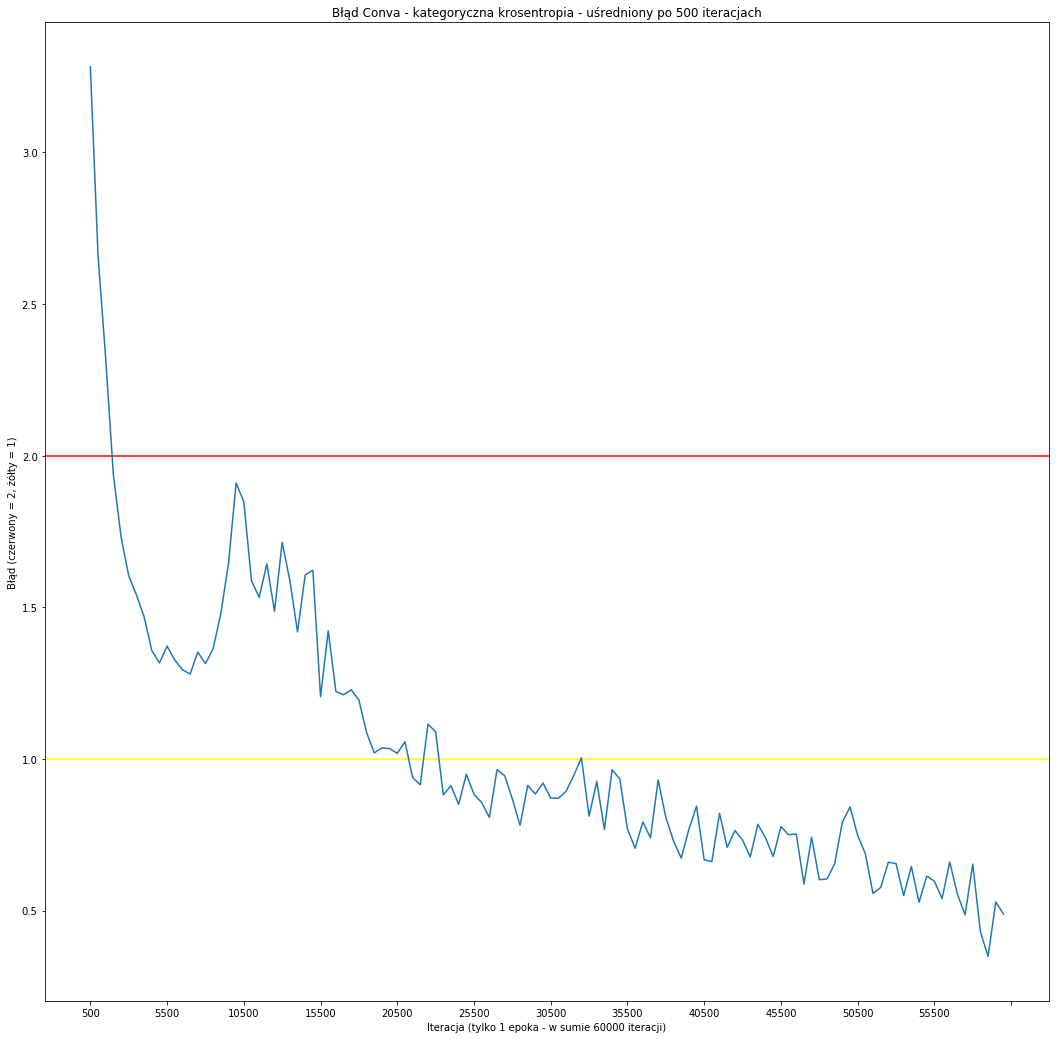

In [138]:
print(w2.shape)
fig, ax=plt.subplots(1, 1, figsize=(18,18))
dt=loopz
kgbo=500
dt2=dt//kgbo
ss=10

dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(sk[i*kgbo:(i+1)*kgbo])/kgbo

ax.set_title('Błąd Conva - kategoryczna krosentropia - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko 1 epoka - w sumie {} iteracji)'.format(loopz))
ax.set_xticklabels(range(kgbo, loopz+1, kgbo*ss))
ax.set_xticks(range(0, loopz//kgbo+1, ss))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1)'.format(loopz))
ax.axhline(2, color='red')
ax.axhline(1, color='yellow')
ax.plot(dkkk)
plt.show()

In [141]:
num=10000
won=0

for jj in range(num):
    img=testX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""

    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])

    """m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""


    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    s2=sigmoid_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)

    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[testy[jj],0]=1
    der, suma=cost(dp, s4)
    mxi=0
    for i in range(10):
        if (s4[i,0]>s4[mxi,0]):
            mxi=i
    if (mxi==testy[jj]):
        won+=1    
    #print(mxi, testy[jj])
print('Skutecznosc na {} testach: {}'.format(num, won/num))

Skutecznosc na 10000 testach: 0.8991


In [32]:
##Od tego miejsca śmieci do debugu
###
###
###


k1=np.asarray([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
k1=k1.reshape(k1.shape[0], k1.shape[1], 1)
mathr=np.asarray([[1,2,3],[-1,-2,-3],[-10,10,20]])
c1=conv_forw(k1, mathr)
#c1=c1.reshape(c1.shape[0], c1.shape[1])
kgb=pool_forw(k1, (2,2))

print(kgb[1].reshape(kgb[1].shape[0], kgb[1].shape[1]))


[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]]


In [139]:
dkk=[0]*10
for i in range(100):
    dkk[testy[i]]+=1
print(dkk)


#print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2].shape)
#print(print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]))
#print(z)
#TT=(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]==z)
#print(TT[TT==False])

[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]


(1048, 698, 3) (7, 7)
2 2
(1050, 705, 3) (7, 7)
(150, 100)
150 100


In [17]:
mat=mymat
Y=np.ndarray((z.shape[0]*mat.shape[0], z.shape[1]*mat.shape[1]*3, z.shape[2]*2), dtype='float64')
t1=time.time()
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        for ij in range(z.shape[2]):
            Y[i:i+1,j,ij]=1
t2=time.time()
print(t2-t1)
print(Y.shape[0]*Y.shape[1]*Y.shape[2])

7.269612789154053
29625912


In [10]:
k=[random.random() for i in range(10)]
print(k)

[0.5984270187569013, 0.9671677742926911, 0.7976401137331915, 0.053760428992956966, 0.25749371422047285, 0.16253284123891132, 0.9060344103299387, 0.2756248627348449, 0.5445703657707015, 0.39006604163079217]


In [ ]:
z=cv2.imread("E:\W3\GGHard.jpg")
#z=z/255
mymat=np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
z=conv_forw(z, mymat)
z=relu(z)
t1=time.time()
z, dt=pool_forw(z,(7,7))
t2=time.time()
print(t2-t1)
print(dt.shape)
#z=pool(z,(7,7))

"""fig, ax=plt.subplots(1,1,figsize=(20,20))
ax.imshow(z)
ax.axis('off')
plt.show()"""

In [ ]:
def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_forw2(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')    
    
    print(Z.shape[0]*Z.shape[1]*mat.shape[0]*mat.shape[0])
    xz1=mat.shape[0]
    xz2=mat.shape[1]
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            ii=0
            while (ii<xz1):
                jj=0
                while(jj<xz2):
                    Z[i,j]=1
                    jj+=1
                ii+=1
    return Z
            
B=np.asarray([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kurl=r"E:\W3\GGHard.jpg"
kk=cv2.imread(kurl)

t1=time.time()
nightmare=conv_forw2(kk, B)
t2=time.time()
print(t2-t1)
t1=time.time()
nightmare2 = ndimage.convolve(kk.astype('int64'), B.reshape(3,3,1))
t2=time.time()
print(t2-t1)

fig, ax=plt.subplots(1,2,figsize=(22,22))
ax[0].imshow(nightmare2)
ax[0].axis('off')
ax[1].imshow(nightmare)
ax[1].axis('off')
plt.show()

In [ ]:
print(kk.shape)
print(nightmare2[1:nightmare2.shape[0]-1,1:nightmare2.shape[1]-1])
print(nightmare)

def relu(x):
    if (x<0):
        return 0
    return x

def pool_forward(X):
    Y=pd.Series([True]*X.shape[0])
    Y2=pd.Series([True]*X.shape[1])
    
    Y[Y.index%2==0]=False
    Y2[Y2.index%2==0]=False 
    KK1=X[Y][:,Y2]
    KK2=X[Y][:,~Y2]
    KK3=X[~Y][:,Y2]
    KK4=X[~Y][:,~Y2]
    
    Dt=KK1*0+1
    Exit=KK1
    Dt[Exit<KK2]=2
    Exit[Exit<KK2]=KK2[Exit<KK2]
    Dt[Exit<KK3]=3
    Exit[Exit<KK3]=KK3[Exit<KK3]
    Dt[Exit<KK4]=4
    Exit[Exit<KK4]=KK3[Exit<KK4]
    
    return (Dt, KK1)

t1=time.time()
Res, KK=pool_forward(nightmare)
t2=time.time()
print(t2-t1)

print(nightmare[:4,:4,0])

#Dodanie wersetu w 2 wymiarze
print(KK.shape)
s=[0]*KK.shape[0]*KK.shape[2]
s=np.asarray(s).reshape(KK.shape[0], 1, 3)
GG=np.append(KK, s, axis=1)
print(GG.shape)

In [98]:
n1, n2 = np.arange(5), np.arange(5)
Y=m7[0]
n1=np.arange(m7[0].shape[0])

f1=pd.Series([1]*Y.shape[0])
f2=pd.Series([1]*Y.shape[1])
f3=pd.Series([1]*Y.shape[2])

n1=np.asarray(f1[(f1.index%2)==0].index)
n2=np.asarray(f2[(f2.index%2)==1].index)
n3=np.asarray(f3.index)

m7[0][n1,n2]=13
print(m7[0][np.ix_(n1, n2,n3)].shape)
print(m7[0].shape)

(3, 3, 3)
(6, 6, 3)


In [119]:
print(math.exp(-100000))

0.0


In [71]:
print(matt)

[[[-1.80641111e-01  1.01303406e+00  5.68658521e-02]
  [-1.50180242e-01 -4.49518778e-01  2.29888229e-01]
  [-1.49464212e-01  1.79568202e-02  5.63098800e-01]]

 [[ 3.57100431e-01 -1.24985684e-01 -1.44566969e-01]
  [ 5.21873333e-01  9.49807180e-01  8.12153844e-01]
  [-1.77566089e-01 -6.69357460e-01  4.61081356e-01]]

 [[ 8.51013511e-01 -3.23042716e-01 -5.74604168e-01]
  [ 1.54445548e-01 -2.12365245e-01 -6.03171539e-01]
  [ 1.08646375e+00 -3.59921150e-01 -3.14678410e-01]]

 [[-3.09463601e-01 -8.49167675e-01  4.21892386e-01]
  [-9.78466819e-02  4.85793427e-01  4.07272130e-01]
  [-4.93156935e-01 -2.03789750e-01 -7.12313815e-02]]

 [[-8.53628217e-02 -7.04846645e-04  6.31339778e-03]
  [ 5.44888689e-01 -4.57835885e-01 -4.06130290e-01]
  [-7.09531689e-02 -4.13826322e-01  3.46471223e-01]]

 [[-3.29109786e-01  6.69617081e-01  4.80251536e-01]
  [-4.98654748e-01  5.22653924e-02 -4.02342825e-01]
  [ 3.54233047e-01 -4.11030534e-01 -4.91160409e-02]]

 [[-1.87180082e-01  8.45536081e-04  4.05606974e-02]
